<a href="https://colab.research.google.com/github/Lewis34cs/corona_audio/blob/main/covid_proj_p2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Capstone Project Part 2

Author: Chris Lewis

Contact info: lewis34cs@gmail.com

Link to Github repo: https://github.com/Lewis34cs/corona_audio

#### COVID-19 Exploration in statistics and diagnosis via imaging and audio

>Since the beginning of 2020, COVID-19 has run rampant throughout the entirety of the globe, resulting in over 100 million cases and 2 million deaths. While vaccines are beginning to be pushed out as our new line of defense, my project's goal is to try and identify other ways to detect COVID-19 in a patient to help slow the spread. In this project, I focus on two different ways to identify COVID-19: multi classification via chest x-rays and binary classification through coughing audio. Both parts will be using Sequential Convolutional Neural Networks. 

>To run the Google Colab code, you must allow Google Colab to access an account. I will provide links for the data below. Please be sure to save zipped folders for these audio datasets into your google drive so you can access them on Google Colab. The chest x-ray database was obtained via Kaggle's API.


**Audio Datasets Original Sources**:
1. Virufy dataset - Original source: https://github.com/virufy/virufy_data
2. CoughVid dataset - Original source: https://zenodo.org/record/4048312#.YBnSHOhKhPY



---
Link for functions and zipped audio datasets: https://drive.google.com/drive/folders/1IQ758RksB0ayUhOohfGh8s25MT4taMsI?usp=sharing


Click on the "add to drive" button once you've clicked on the Google Drive link above to add the datasets and functions to your Google Drive
<img src='https://drive.google.com/uc?id=1YYdx9_xhHRsYLqV2X7yUJauG9zKX_LoX'>

WARNING: DO NOT AUTOMATICALLY RUN ALL CELLS IN THIS NOTEBOOK. Please run code in the defined TEST AREAS at your own risk. 

In [1]:
# We must run this in order for colab to be able to access our google drive

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
# We need to import these libraries in order to access the shared folder
import os, sys

In [3]:
# We must install these libraries for our imported functions folder to work
!pip install split-folders
!pip install split-folders tqdm
!pip install pydub
!pip install soundfile
!pip install ffmpeg-python
!pip install zip_files
!pip install lime

     |████████████████████████████████| 276kB 14.0MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-cp36-none-any.whl size=283846 sha256=0a5eda6e28f4e081a2b001a8205b5b4bfdb23ab2d6c30face3ae0fc4c1e6d76a
  Stored in directory: /root/.cache/pip/wheels/4c/4f/a5/0bc765457bd41378bf3ce8d17d7495369d6e7ca3b712c60c89
Successfully built lime


In [62]:
# Set the FOLDER variable as the filepath where the folder containing functions 
#and audio datasets are located in your Google Drive
FOLDER = '/content/drive/MyDrive/chris_lewis_capstone/'
os.listdir(FOLDER)

['public_dataset.zip', 'virufy_data-main.zip', '__pycache__', 'functions.py']

In [63]:
# Defining a path variable (our FOLDER) to add a specific path for the 
# interpreter to search
sys.path.append(FOLDER)

In [64]:
%load_ext autoreload
%autoreload 2
from functions import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Importing Libraries

In [8]:
# Suppressing a specific warning from librosa
warnings.filterwarnings("ignore", message="PySoundFile failed. Trying audioread instead.")

# setting plot background style
plt.style.use('dark_background')

In [9]:
# Viewing where we are in the directory
os.path.abspath(os.curdir)

'/content'

## Obtaining Virufy audio data

In [12]:
# Extracting the contents of our Virufy zipped folder. Please make sure
# you've saved the shared folder at the top of the notebook to your Google Drive

# Making sure we are in the root directory
%cd ~
%cd .. 

# the zipped Coughvid file in your Google Drive
zipped_file= FOLDER + 'virufy_data-main.zip'

start = time.time()
with ZipFile(zipped_file,'r') as zip:
      zip.extractall()
      print('Successfully extracted Virufy dataset')

end = time.time()
time_count(start, end)

/root
/
Successfully extracted Virufy dataset
Time to run cell: 0 seconds


We see that the virufy audio data we have is all the same length (approx. 1.6 secs in length). This is good; we want to make sure our audio is the same length, otherwise the frequencies in the spectrograms we create will vary in size and duration in our images.

### Examining dataframe that came with the audio files

In [13]:
# Defining the root folder for the Virufy dataset
virufy_base = ensure_filepath('/virufy_data-main/clinical/')

In [14]:
virufy_df = pd.read_csv(virufy_base + 'labels.csv')

In [15]:
virufy_df.head()

,date,corona_test,age,gender,medical_history,smoker,patient_reported_symptoms,cough_filename
0,4/21,negative,53,male,"none,",yes,"none,",neg-0421-083-cough-m-53.mp3
1,4/21,positive,50,male,"Congestive heart failure,",no,"Shortness of breath,",pos-0421-084-cough-m-50.mp3
2,4/21,negative,43,male,"none,",no,"Sore throat,",neg-0421-085-cough-m-43.mp3
3,4/21,positive,65,male,"Asthma or chronic lung disease,",no,"Shortness of breath,New or worsening cough,",pos-0421-086-cough-m-65.mp3
4,4/21,positive,40,female,"none,",no,"Sore throat,Loss of taste,Loss of smell,",pos-0421-087-cough-f-40.mp3


In [16]:
virufy_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   date                       16 non-null     object
 1   corona_test                16 non-null     object
 2   age                        16 non-null     int64 
 3   gender                     16 non-null     object
 4   medical_history            16 non-null     object
 5   smoker                     16 non-null     object
 6   patient_reported_symptoms  16 non-null     object
 7   cough_filename             16 non-null     object
dtypes: int64(1), object(7)
memory usage: 1.1+ KB


Note that our dataframe has 16 patients. While we have more audio data because the data was segmented, we should find more audio data if we want to train a model without worrying about overfitting to our small sample size.

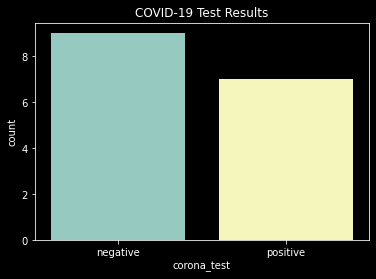

In [17]:
sns.countplot(x='corona_test', data=virufy_df)
plt.title('COVID-19 Test Results')
plt.show()

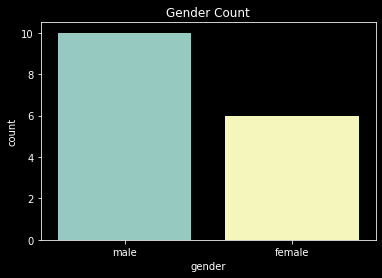

In [18]:
sns.countplot(x='gender', data=virufy_df)
plt.title('Gender Count')
plt.show()

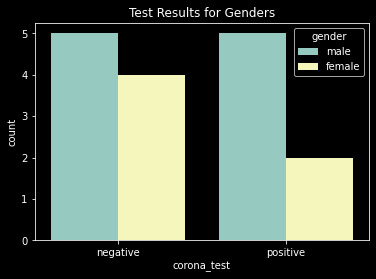

In [19]:
sns.countplot(x='corona_test', hue='gender', data=virufy_df)
plt.title('Test Results for Genders')
plt.show()

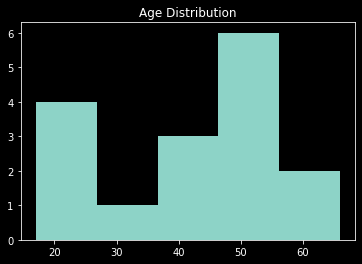

In [20]:
plt.hist(x='age', data=virufy_df, bins='auto')
plt.title('Age Distribution')
plt.show()

In [21]:
virufy_df['medical_history'].value_counts()

none,                              12
Diabetes with complications,        2
Congestive heart failure,           1
Asthma or chronic lung disease,     1
Name: medical_history, dtype: int64

In [22]:
virufy_df['patient_reported_symptoms'].value_counts()

none,                                                                                                             6
Shortness of breath,New or worsening cough,                                                                       2
New or worsening cough,                                                                                           2
Shortness of breath,                                                                                              1
Fever, chills, or sweating,New or worsening cough,Sore throat,                                                    1
Fever, chills, or sweating,Shortness of breath,New or worsening cough,Sore throat,Loss of taste,Loss of smell,    1
Shortness of breath,Sore throat,Body aches,                                                                       1
Sore throat,Loss of taste,Loss of smell,                                                                          1
Sore throat,                                                            

In [23]:
asympto_df = virufy_df[virufy_df['patient_reported_symptoms'] == 'none,']

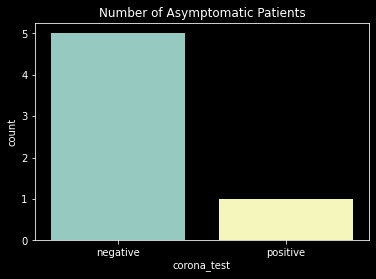

In [24]:
# The majority of patients in this dataset who had COVID-19 did have at least 
# one symptom. Only one patient was asymptomatic.
sns.countplot(x='corona_test', data=asympto_df)
plt.title('Number of Asymptomatic Patients')
plt.show()

### Audio Playground

In [25]:
# Folder containing our segmented audio files
# Do not change this variable
audio_base_folder = virufy_base + 'segmented/'

In [26]:
# Viewing subfolders in our audio_base_folder
folder_contents(audio_base_folder)

Contents of /virufy_data-main/clinical/segmented/:



['neg', 'pos']

In [27]:
# Counting the number of files in each subfolder
num_items(audio_base_folder, targets=['neg', 'pos'])

/virufy_data-main/clinical/segmented/
Number of items in neg: 73
Number of items in pos: 48
Total number of items: 121


121

In [28]:
start = time.time()

#Creating an empty dictionary to hold the duration for each file
audio_dict = {}
for folder in os.listdir(audio_base_folder):
  for mp3 in os.listdir(audio_base_folder + folder):
    signal, sr = librosa.load(audio_base_folder + folder + '/' + mp3)
    audio_dict[mp3] = librosa.get_duration(signal, sr)
    
end = time.time()
time_count(start, end)

# Viewing the mean, std, min, max, etc of the duration of our virufy audio
pd.Series(audio_dict.values()).describe()

Time to run cell: 37 seconds


count    121.000000
mean       1.599895
std        0.000029
min        1.599864
25%        1.599864
50%        1.599909
75%        1.599909
max        1.599955
dtype: float64

Viewing an audiofile using librosa

In [29]:
# positive audio example end address
audio_example = os.listdir(audio_base_folder +'pos')[3]
audio_example

'pos-0421-084-cough-m-50-7.mp3'

In [30]:
# Creating the filepath for an audio example
target_audio = audio_base_folder+'pos/'+audio_example
target_audio

'/virufy_data-main/clinical/segmented/pos/pos-0421-084-cough-m-50-7.mp3'

In [31]:
# Viewing sample rate of the audio file
rate = AudioSegment.from_mp3(target_audio).frame_rate
print(f"Sample rate from the mp3 file: {rate}")

Sample rate from the mp3 file: 48000


In [32]:
target_rate = 48000
i = 0
for status in os.listdir(audio_base_folder):
  address = audio_base_folder + status
  for audiof in os.listdir(address):
    audio_address = address + '/' + audiof
    song = AudioSegment.from_mp3(audio_address)
    if song.frame_rate != target_rate:
      i += 1
    else:
      continue
print(f'Number of audio files that do not have a sample rate of 48,000: {i}')

Number of audio files that do not have a sample rate of 48000: 0


We know that all the audio files in our virufy dataset have a sample rate of 48000

In [33]:
# two variables: the signal and the sample rate
#loading in a specific example to test out
signal, sr = librosa.load(target_audio, sr=48000)
len(signal), sr

(76793, 48000)

In [34]:
# Librosa gives us back an array --> our audio signal
# and a number which represents our sample rate
# sample rate is how many samples we have in a second
# We get back the default sample rate, which is 22050
print(type(signal), type(sr))
print(signal.shape, sr)

<class 'numpy.ndarray'> <class 'int'>
(76793,) 48000


In [35]:
#Multiplying our sample rate by the length of our audio file
# It should give us back a float very close to the shape of our signal
48000 * 1.5999

76795.20000000001

In [36]:
# Viewing a portion of the array of our signal variable
signal[:10]

array([ 0.09899902,  0.10437012,  0.06893921,  0.05303955,  0.01849365,
       -0.03329468, -0.05197144, -0.05944824, -0.08761597, -0.12158203],
      dtype=float32)

In [37]:
# listening to the audio file
ipd.Audio(signal, rate=sr)

Visualizing our audio example's waveform using librosa.display (ldp)


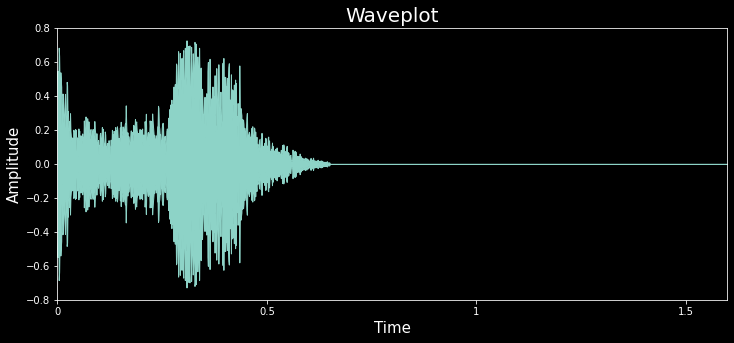

In [38]:
plt.figure(figsize=(12, 5))
ldp.waveplot(signal, sr=sr)
plt.title('Waveplot', fontsize=20)
plt.xlabel('Time', fontsize=15)
plt.ylabel('Amplitude', fontsize=15)
plt.show()

Text(0, 0.5, 'Magnitude')

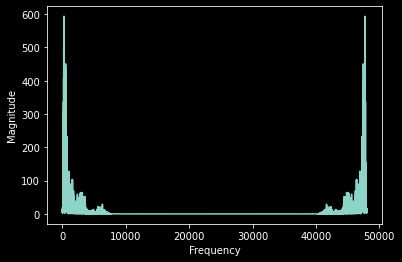

In [39]:
#Fast Fourier Transform
fft = np.fft.fft(signal)

# These magnitudes indicate the contribution of each frequency in the sound. The
# larger the magnitude, the heavier the contribution of the frequency.
magnitude = np.abs(fft)
frequency = np.linspace(0, sr, len(magnitude))

# Plotting our Fast Fourier Transformation
plt.plot(frequency, magnitude)
plt.xlabel('Frequency')
plt.ylabel('Magnitude')

We notice the Fast Fourier Transformation plot is actually symmetrical. Without getting into too much detail (unnecessary for what we are doing), we only need the first half of the plot.

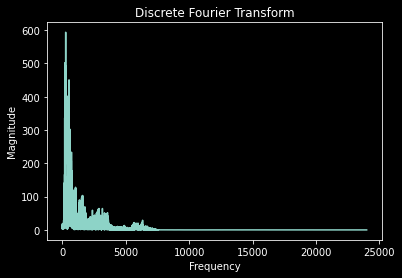

In [40]:
#Fast Fourier Transformation
fft = np.fft.fft(signal)

# These magnitudes indicate the contribution of each frequency in the sound
magnitude = np.abs(fft)

# mapping the magnitude to the relative frequency bins using np.linspace()
frequency = np.linspace(0, sr, len(magnitude))

# We only need the first half of the magnitude and frequency to visualize the FFT
left_mag = magnitude[:int(len(magnitude)/2)]
left_freq = frequency[:int(len(frequency)/2)]

plt.plot(left_freq, left_mag)
plt.title('Discrete Fourier Transform')
plt.xlabel('Frequency')
plt.ylabel('Magnitude')
plt.show()

Here we can see that the majority of the energy resides in the lower frequencies. The only issue with the FFT is the fact that it is static; there is no time associated with this plot. So in order to incorporate time into our audio to see what frequencies impact at what time, we should use the Short-Time Fourier Transformation.

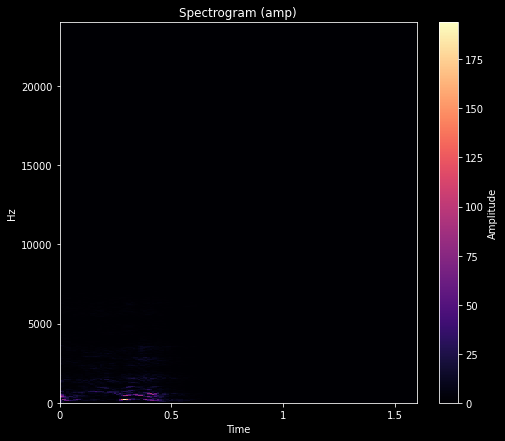

In [41]:
# number of samples per fft
# this is the number of samples in a window per fast fourier transform
n_fft = 2048

# The amount we are shifting each fourier transform (to the right)
hop_length = 512

#Trying out Short-time Fourier Transformation on our audio data
audio_stft = librosa.core.stft(signal, hop_length=hop_length, n_fft=n_fft)

# gathering the absolute values for all values in our audio_stft variable
spectrogram = np.abs(audio_stft)

# Plotting the short-time Fourier Transformation
plt.figure(figsize=(8, 7))
ldp.specshow(spectrogram, sr=sr, x_axis='time', y_axis='hz', hop_length=hop_length)
plt.colorbar(label='Amplitude')
plt.title('Spectrogram (amp)')
plt.show()

As we can see (or not see), most of the frequencies in our audio contribute very little amplitude to the overall sound. 

Because what we are looking for is not linear, like loudness, we are going to take the log of our sounds amplitude and turn it into decibels.

Humans experience frequency logarithmically, not linearly.

In [42]:
def to_spectrogram(signal, sr, hop_length, n_fft=2048, ref=1, cmap='magma', 
                   fmax=9000, vmin=None, vmax=None, figsize=(10, 8)):
  """
  Definition:
  Plots a spectrogram of a signal.

  Args:
  signal: Required. An audio time series, usually an numpy 1 dimensional array.
  sr: Required. The sample rate of the signal.
  hop_length: Required. The amount to shift each fast fourier transform.
  n_fft: Required. The number of samples in a window per fast fourier transform.
  cmap: default = 'magma'. The color palette of the spectrogram.

  Returns:
  Plots a spectrogram via librosa.display.specshow()
  """
  stft_signal = librosa.core.stft(y=signal, hop_length=hop_length, n_fft=n_fft)
  spectrogram = np.abs(stft_signal)
  amp_to_db = librosa.amplitude_to_db(spectrogram, ref=ref)
  fig = plt.figure(figsize=figsize)
  if (vmin != None) and (vmax != None):
    ldp.specshow(amp_to_db, sr=sr, x_axis='time', y_axis='hz', cmap=cmap, 
                hop_length=hop_length, fmax=fmax, vmin=vmin, vmax=vmax)
  else:
    ldp.specshow(amp_to_db, sr=sr, x_axis='time', y_axis='hz', cmap=cmap, 
                hop_length=hop_length, fmax=fmax)
  plt.title("Spectrogram (Decibels)")
  plt.ylim(0, fmax)
  plt.colorbar(label='dB')
  # axes = fig.get_axes()
  # return fig, axes

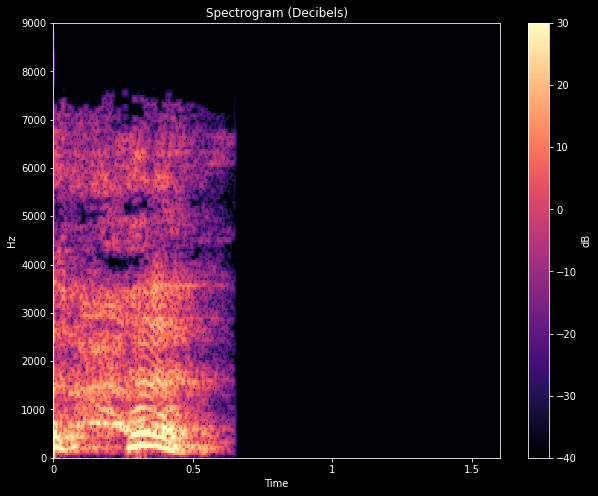

In [43]:
to_spectrogram(signal, sr=48000, hop_length=128, n_fft=1024, vmin=-40, vmax=30)

>By switching from a scale in amplitude to decibels, we create an image with more information to give to our model.

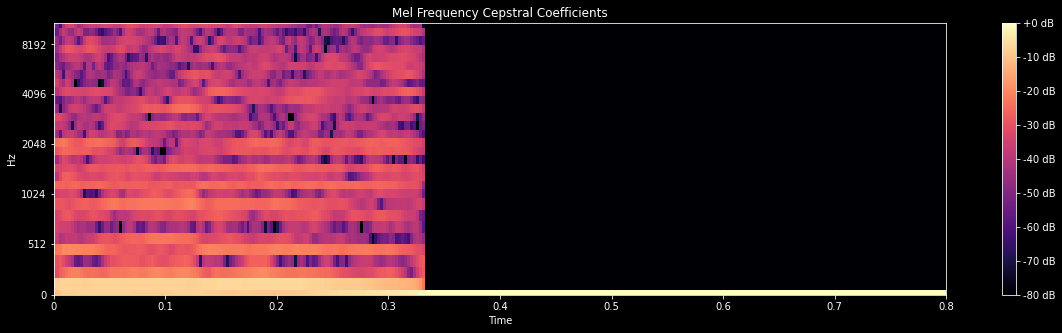

In [44]:
# Creating an MFCC plot
mfccs = librosa.feature.mfcc(signal, n_fft=2048, hop_length=256, n_mfcc=30, n_mels=128)
# PLotting the MFCCs
plt.figure(figsize=(20,5))
ldp.specshow(librosa.amplitude_to_db(mfccs, ref=np.max), sr=sr, x_axis='time', y_axis='mel',
             hop_length=128, cmap='magma')#, vmin=-70, vmax=-5)
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Frequency Cepstral Coefficients')
plt.show()

Fourier Transform:
- decompose complex periodic sound into sum of sine waves oscillating at different frequencies
- allows us to know the different elements that create a complex sound
- moves our audio from the time domain into the frequency domain
- it's a snapshot of the audio information

Short-Time Fourier Transform:
- computes several fourier transforms at different intervals
- doing so allows it to preserve information about time and the way the sound evolves over time
- makes it a time domain feature
- the amount different intervals are indicated by the frame size, which creates a spectrogram
- x-axis = time
- y-axis = frequency
- third axis = presence of a frequency
- the color tells us how prominent a certain frequency is at a certain period in time

Mel Frequency Cepstral Coefficients (MFCCs):
- Captures the timbral/textural aspects of sound
- time domain feature
- Approximated towards the human auditory system
- calculated at each frame
- usually want to use 13-40 coefficients for audio data
- usually used for speech recognition, music genre classification, music instrument classification
- could use MFCCs to help collect coughing audio data?

Mel Spectrograms:
- time-frequency representation
- perceptually relevant amplitude representation
- preceptually relevant frequency representation
- steps: extract stft, convert amplitude to dBs, convert frequency to mel-scale

to convert frequencies to the mel-scale:
1. choose a number of mel bands
2. construct mel filter banks
3. Apply filter banks to mel spectrogram

How many mel bands should you choose? Like learning rate, it depends on the problem.


#### defining mel spectrogram function

In [55]:
def to_mel_spectro(signal, sr, hop_length, n_fft, cmap='magma', 
                    ref=np.max, figsize=(5, 4), vmin=None, vmax=None, n_mels=128):
  """
  Definition:
  Plots a mel-spectrogram of a signal.

  Args:
  signal: Required. An audio time series, usually an numpy 1 dimensional array.
  sr: Required. The sample rate of the signal.
  hop_length: Required. The amount to shift each fast fourier transform.
  n_fft: Required. The number of samples in a window per fast fourier transform.
  cmap: default = 'magma'. The color palette of the spectrogram.
  ref: default = np.max. Tells the librosa.power_to_db() how to scale the values.
  When ref=np.max, it will make the highest value 0, and everything else will be 
  lower than it, respectively so. Does not change the color distribution of the
  spectrogram.
  figsize: default = (10, 8). A tuple representing the desired figure size for 
  the plot.

  Returns:
  Plots a spectrogram via librosa.display.specshow()
  """

  mel_signal = librosa.feature.melspectrogram(y=signal, sr=sr, hop_length=hop_length, 
                                              n_fft=n_fft, n_mels=n_mels)
  power_to_db = librosa.power_to_db(mel_signal, ref=ref)
  plt.figure(figsize=figsize)
  if (vmin != None) and (vmax != None):
    ldp.specshow(power_to_db, sr=sr, x_axis='time', y_axis='mel', cmap=cmap, 
                hop_length=hop_length, vmin=vmin, vmax=vmax)
  else:
    ldp.specshow(power_to_db, sr=sr, x_axis='time', y_axis='mel', cmap=cmap, 
                hop_length=hop_length)
  plt.title("Mel-Spectrogram")
  plt.colorbar(label='dB')
  plt.show()

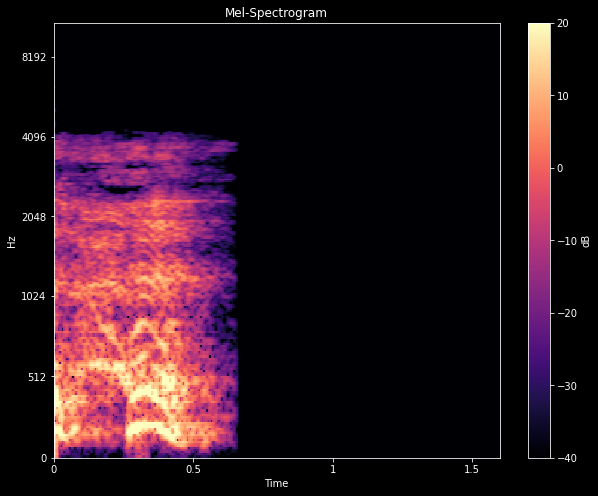

In [56]:
to_mel_spectro(signal, sr, hop_length=256, n_fft=2048, figsize=(10,8), vmin=-40, 
               vmax=20, ref=1, n_mels=256)

A mel-spectrogram is a spectrogram where the frequencies are converted to the mel-scale. According to the University of California, the mel-scale is “a perceptual scale of pitches judged by listeners to be equal in distance from one another”. We can picture this as notes on a musical scale:

From C to D is one whole step, and from D to E is another whole step. Perceptually to the human ears, the step sizes are equal. However if were were to compare these steps in hertz, they would not be equal steps. A C is around 261.63 Hz, a D is 293.66 Hz, and an E is 329.63 Hz. 

C to D difference = 32.03 Hz
D to E difference = 35.37 Hz

As the notes go higher in octave, the difference between the steps dramatically increases. Mel-spectrograms provide a perceptually relevant amplitude and frequency representation.


## Recommendation:

When working with spectrograms created from human audio, taking the log of the amplitude and converting it to decibels will give your model more to look at, and allow it to learn more from each image. Since we are working with coughing audio, converting the frequency to the mel-scale allows us to peer more into the tonal relationship of the frequencies. 

### Creating & Saving Mel-Spectrograms for Virufy Dataset

In [59]:
# Defining our target folder and constant variables

# Please define a filepath you want to save the virufy mel-spectrogram images to
# in the variable 'melspectro_base'
melspectro_base = ensure_filepath('/viru_melspectro_images/')

SAMPLE_RATE = 48000
HOP_LENGTH = 256
N_FFT = 2048
N_MELS = 256
REF = np.max

start = time.time()

# Going through 'pos' and 'neg' folders in root folder
for status in os.listdir(audio_base_folder):

  # Identifying correct directory for each 'pos' and 'neg' subfolder and
  # accessing each audio file within these folders
  step = audio_base_folder + status

  # making folder to store images
  new_folder = melspectro_base + status + '/'
  os.makedirs(new_folder , exist_ok=True)

  for subfile in tqdm(os.listdir(step), desc=status):
    # Creating a variable that holds the filepath for an audio file
    audio_file = step + '/' + subfile
    # Loading the signal and sample rate for an audio file
    signal, sr = librosa.load(audio_file, sr=SAMPLE_RATE)

    # Calling plt.interactive(False) means that we choose to manually show and destroy
    # our plots 
    plt.interactive(False)

    # Creating our mel-spectrograms
    mel_signal = librosa.feature.melspectrogram(y=signal, sr=SAMPLE_RATE, 
                                                hop_length=HOP_LENGTH, 
                                                n_fft=N_FFT, n_mels=N_MELS)
    power_to_db = librosa.power_to_db(mel_signal, ref=REF)
    # Creating figure
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(111)
    # Hiding axes and image frame
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.set_frame_on(False)

    # Displaying our spectrograms
    ldp.specshow(power_to_db, sr=SAMPLE_RATE, cmap='magma', hop_length=HOP_LENGTH)
    
    # Saving each spectrogram into its respective folder
    # subfile[:-4] is a string of the subfile without the ending extension '.mp3'
    # We add the '.png' extension to the end of our new spectrogram images instead
    plt.savefig(fname=new_folder + subfile[:-4] + '.png', dpi=400, 
                bbox_inches='tight',pad_inches=0)
    
    # We then manually close pyplot, clear the figure, close the fig variable, 
    # and then close the figure window
    plt.close()    
    fig.clf()
    plt.close(fig)
    plt.close('all')

# Display the time it took to run the cell in seconds
end = time.time()
time_count(start, end)

pos: 100%|██████████| 48/48 [01:14<00:00,  1.54s/it]

Time to run cell: 186 seconds


In [65]:
# Comparing pos and neg spectrogram images we created
neg_img = mpimg.imread(melspectro_base + 'neg/neg-0421-083-cough-m-53-0.png')
pos_img = mpimg.imread(melspectro_base + 'pos/pos-0421-084-cough-m-50-0.png')

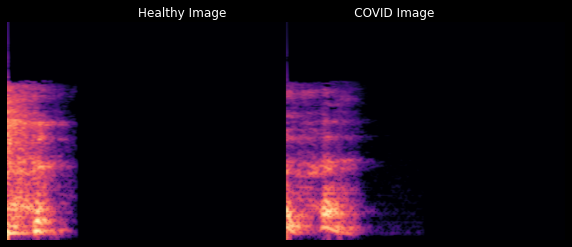

In [66]:
# Using np.hstack() to show our images side by side
res = np.hstack((neg_img, pos_img))
# Creating a figure and adding a subplot
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
# plotting the horizontal stack using plt.imshow()
plt.imshow(res)
plt.title('Healthy Image                                 COVID Image')

# Hiding our axes and frame
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.set_frame_on(False)
plt.show()

When looking at the spectrograms, there's not much we can take away just by looking at them. We notice the coughs are roughly the same length in duration, and the prominence of some frequencies of sound may be slightly different when comparing patients (male vs female, older vs younger, etc). 

### Modeling off of the virufy spectrogram images

In [68]:
# Creating train, test, val folders for our virufy dataset
# Please define where you would like to save the train, test, and validation 
# folders for the spectrogram images in the 'spectro_ttv_folder' variable
spectro_ttv_folder = ensure_filepath('/virufy_spectro_ttv/')

splitfolders.ratio(input=melspectro_base, 
                    output=spectro_ttv_folder, 
                    seed=42, ratio=(0.7, 0.1, 0.2)) # ratio order: train, val, test

Copying files: 121 files [00:00, 4107.97 files/s]


In [69]:
# Removing the folder containing the virufy mel-spectrograms
try:
  shutil.rmtree(melspectro_base)
except:
  pass

In [70]:
folder_check(spectro_ttv_folder)

/virufy_spectro_ttv/train/
Number of items in neg: 51
Number of items in pos: 33
Total number of items: 84

/virufy_spectro_ttv/test/
Number of items in neg: 15
Number of items in pos: 11
Total number of items: 26

/virufy_spectro_ttv/val/
Number of items in neg: 7
Number of items in pos: 4
Total number of items: 11


Total image count: 121


In [71]:
virufy_train_folder, virufy_test_folder, virufy_val_folder =create_ttv(spectro_ttv_folder)

In [72]:
# Defining our image size
IMG_SIZE = (300,240)

# Creating ImageDataGenerators for train and test/val
viru_train_datagen = ImageDataGenerator(rescale=1./255, 
                                        #width_shift_range=0.1, 
                                        brightness_range=(0.9, 1.2))
viru_test_val_datagen = ImageDataGenerator(rescale=1./255)

In [73]:
viru_train_gen = viru_train_datagen.flow_from_directory(virufy_train_folder, 
                                                        target_size=IMG_SIZE,
                                                        batch_size=32, 
                                                        class_mode='binary')
                                                        
viru_test_gen = viru_test_val_datagen.flow_from_directory(virufy_test_folder, 
                                                        target_size=IMG_SIZE,
                                                        batch_size=32, 
                                                        class_mode='binary', 
                                                        shuffle=False)

viru_val_gen = viru_test_val_datagen.flow_from_directory(virufy_val_folder,
                                                        target_size=IMG_SIZE,
                                                        batch_size=32, 
                                                        class_mode='binary')

Found 84 images belonging to 2 classes.
Found 26 images belonging to 2 classes.
Found 11 images belonging to 2 classes.


In [74]:
class_weights_dict = make_class_weights(viru_train_gen)
INPUT_SHAPE = viru_train_gen.image_shape
print(INPUT_SHAPE)

{0: 0.8235294117647058, 1: 1.2727272727272727}
(300, 240, 3)


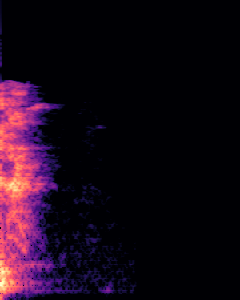

In [75]:
ex_image = next(viru_train_gen)[0][0]
array_to_img(ex_image)

In [ ]:
def viru_spectro_model(shape='', opt=tf.keras.optimizers.Adam(), 
                        metrics=['acc', tf.keras.metrics.Precision(name='precision'),
                                        tf.keras.metrics.Recall(name='recall'), 
                                        tf.keras.metrics.AUC(name='auc')],
                        loss='binary_crossentropy', 
                        verbose=1):
  """
  Definition:
  Creates and compiles a neural network model. 

  Args:
  shape: default = ''. The input shape of the images to be passed in to the 
  neural network. The size must be the same as the images being passed in.
  metrics: default = ['acc', tf.keras.metrics.Precision(name='precision'),
                             tf.keras.metrics.Recall(name='recall'), 
                             tf.keras.metrics.AUC(name='auc')].
           The metrics that are to be analyzed and plotted from the 
           training of the model.
  verbose: default = 1. If 1, prints a summary of the model upon compilation.

  Returns:
  The model, along with the model.summary() if verbose = 1.
  """
  if len(shape) < 1:
    print('Please define input shape!')
  else:
    model = Sequential()
    model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=shape))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(64, (3,3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    # model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    # model.add(MaxPooling2D((2, 2)))

    # model.add(layers.Conv2D(256, (3, 3), activation='relu'))
    # model.add(MaxPooling2D((2, 2)))
    
    model.add(Flatten())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dropout(0.2))

    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.2))

    model.add(layers.Dense(128, activation='relu'))
    #model.add(layers.Dropout(0.2))

    model.add(layers.Dense(64, activation='relu'))

    model.add(layers.Dense(32, activation='relu'))

    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(loss=loss, optimizer=opt, metrics=metrics)
    if verbose:
      print(model.summary())
    return model

In [ ]:
viru_model1 = viru_spectro_model(shape=INPUT_SHAPE, opt=tf.keras.optimizers.Adam(0.001, decay=0.0001))

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 298, 238, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 149, 119, 32)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 147, 117, 64)      18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 73, 58, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 270976)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               138740224 
_________________________________________________________________
dropout (Dropout)            (None, 512)              

Epoch 1/25
3/3 [==============================] - 15s 6s/step - loss: 0.9946 - acc: 0.4283 - precision: 0.3885 - recall: 0.8030 - auc: 0.5128 - val_loss: 0.6417 - val_acc: 0.6364 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7143
Epoch 2/25
3/3 [==============================] - 12s 4s/step - loss: 0.7511 - acc: 0.5019 - precision: 0.4164 - recall: 0.6020 - auc: 0.4828 - val_loss: 0.6880 - val_acc: 0.3636 - val_precision: 0.3636 - val_recall: 1.0000 - val_auc: 0.8929
Epoch 3/25
3/3 [==============================] - 12s 4s/step - loss: 0.6776 - acc: 0.4743 - precision: 0.4112 - recall: 0.8229 - auc: 0.6353 - val_loss: 0.6667 - val_acc: 0.8182 - val_precision: 0.7500 - val_recall: 0.7500 - val_auc: 0.8214
Epoch 4/25
3/3 [==============================] - 12s 4s/step - loss: 0.6879 - acc: 0.5158 - precision: 0.4108 - recall: 0.5614 - auc: 0.5437 - val_loss: 0.6676 - val_acc: 0.8182 - val_precision: 0.7500 - val_recall: 0.7500 - val_auc: 0.8750
Epoch 5/25
3/3 [========

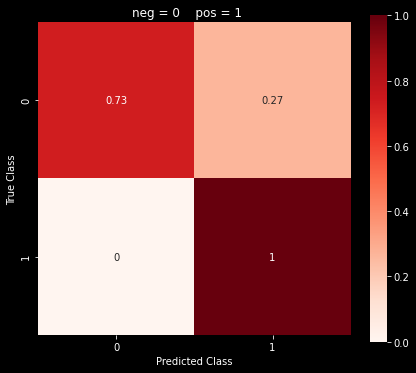

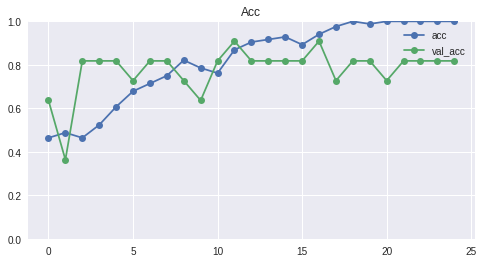

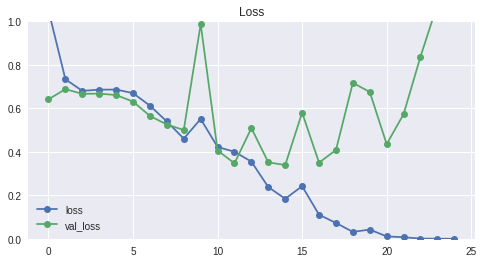

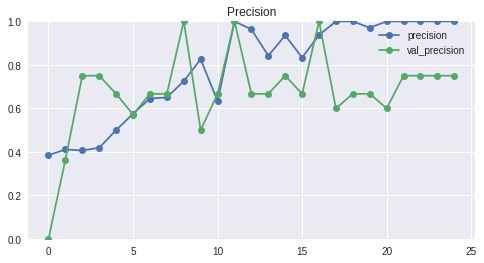

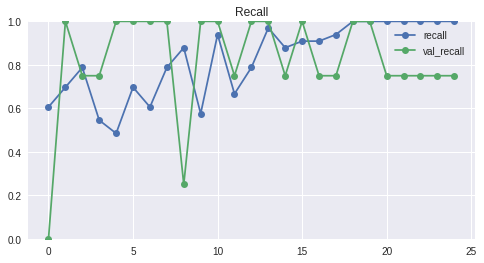

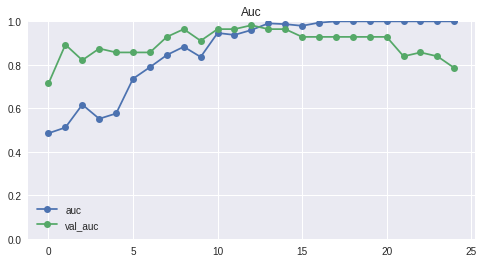

------------------------------------------------------------
1/1 [==============================] - 3s 3s/step - loss: 1.2990 - acc: 0.8462 - precision: 0.7333 - recall: 1.0000 - auc: 0.9152
loss score: 1.2989661693572998
accuracy score: 0.8461538553237915
precision score: 0.7333333492279053
recall score: 1.0
auc score: 0.9151515364646912

Time to run cell: 310 seconds


In [ ]:
viru_hist1 = fit_plot_report_gen(viru_model1, viru_train_gen, viru_test_gen, 
                                 viru_val_gen, epochs=10, 
                                 class_weights=class_weights_dict)

In [ ]:
# If you would like to save your model, change to run = 1
run = 0
if run:
  # Please specify where you would like to save your model
  store_model_filepath = '/content/drive/MyDrive/gdrive/models/capstone_models/viru_spectro_models/viru_model1'
  os.makedirs(store_model_filepath, exist_ok=True)

  viru_model1.save_model(store_model_filepath)

---------------------------------------------------------
                  Classification Report

              precision    recall  f1-score   support

           0       1.00      0.73      0.85        15
           1       0.73      1.00      0.85        11

    accuracy                           0.85        26
   macro avg       0.87      0.87      0.85        26
weighted avg       0.89      0.85      0.85        26

---------------------------------------------------------


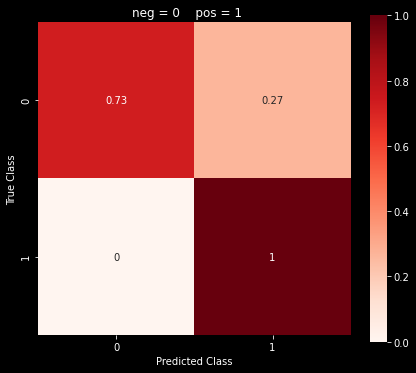

1/1 [==============================] - 3s 3s/step - loss: 0.9429 - acc: 0.8462 - precision: 0.7333 - recall: 1.0000 - auc: 0.9273


[0.9428609013557434,
 0.8461538553237915,
 0.7333333492279053,
 1.0,
 0.9272727370262146]

In [ ]:
# Please define the filepath of the saved virufy model in the 'model_fpath' variable

model_fpath = '/content/drive/MyDrive/gdrive/models/capstone_models/viru_spectro_models/viru_model1'

viru_model = load_model(model_fpath)
class_report_gen(viru_model, viru_test_gen, class_indices=viru_test_gen.class_indices)
viru_model.evaluate(viru_test_gen)

We seem to be getting an ok accuracy with our model. However, when it comes to classifying our spectrogram images with a basic model we've created, the dataset we are working with is too small - only containing around 16 different patients with 121 segmented audio samples. Let's get more audio data from the coughvid dataset and combine it with the virufy dataset.

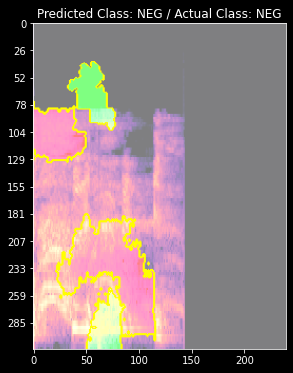

In [ ]:
explain_image(model=viru_model1, generator=viru_train_gen, num_samples=1000, num_feats=5)

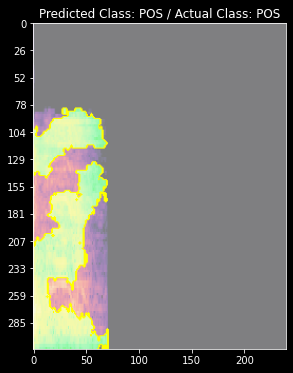

In [ ]:
explain_image(model=viru_model1, generator=viru_train_gen, num_samples=1000, num_feats=5, class_label=1)

In [ ]:
# Removing the virufy spectrogram train, test, and validation folders
try:
  shutil.rmtree(spectro_ttv_folder)
except:
  pass

## Test Area: Audio reduction & MFCC image creation

WARNING: The test area is not suited to be run by others yet - run at your own risk

PLEASE SKIP TO OBTAINING COUGHVID AUDIO DATA SECTION

#### Reducing the length of audio data example

In [ ]:
signal, sr = librosa.load(target_audio)
# Trim the beginning and ending silence in our signal
trimmed_sig, index = librosa.effects.trim(signal)
# Print the durations of the original signal and the trimmed signal
print(librosa.get_duration(signal), librosa.get_duration(trimmed_sig))

1.5998639455782313 1.0681179138321995


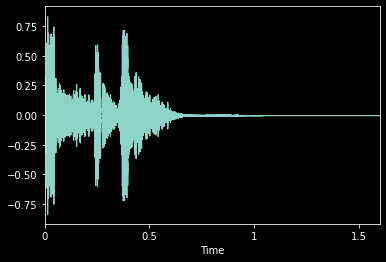

In [ ]:
# Original wave of signal
ldp.waveplot(signal)

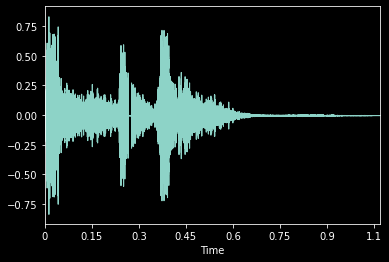

In [ ]:
# Trimmed wave of signal
ldp.waveplot(trimmed_sig)

#### Time stretch example

In [ ]:
# Calculating the delay so we can stretch our trimmed audio to match the 
# original length of the signal
delay = librosa.get_duration(trimmed_sig) / librosa.get_duration(signal)
delay

0.6676304674433766

In [ ]:
# Creating the slowed version of our trimmed signal
slow_signal = librosa.effects.time_stretch(trimmed_sig, delay)

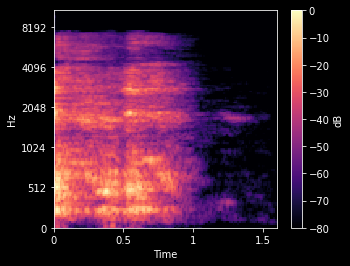

In [ ]:
# Viewing our slowed signal as a mel-spectrogram
to_mel_spectro(slow_signal, sr, hop_length=256, n_fft=1024, figsize=(5, 4))

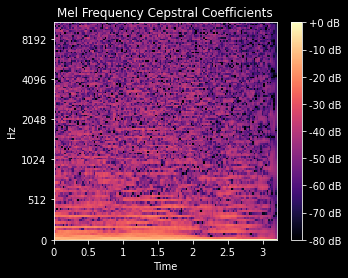

In [ ]:
# Creating an MFCC plot
mfccs = librosa.feature.mfcc(slow_signal, n_fft=1024, hop_length=256, n_mfcc=120, n_mels=256)

# PLotting the MFCCs
plt.figure(figsize=(5, 4))
ldp.specshow(librosa.amplitude_to_db(mfccs, ref=np.max), sr=sr, x_axis='time', y_axis='mel',
             hop_length=hop_length, cmap='magma')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Frequency Cepstral Coefficients')
plt.show()

### Creating virufy MFCC images

In [ ]:
# # Defining our target folder and constant variables
# root_folder = '/virufy_data-main/clinical/segmented/'
# new_folder = '/virufy_reduced_audio/'
# SAMPLE_RATE = 48000

# start = time.time()

# # Going through 'pos' and 'neg' folders in root folder
# for status in os.listdir(root_folder):

#   # Identifying correct directory for each 'pos' and 'neg' subfolder and
#   # accessing each audio file within these folders
#   step = root_folder + status
#   # Creating new folder with subfolders
#   os.makedirs(new_folder + status, exist_ok=True)
#   for subfile in os.listdir(step):
#     # Creating a variable that holds the filepath for an audio file
#     audio_file = step + '/' + subfile
#     # Loading the signal and sample rate for an audio file
#     signal, sr = librosa.load(audio_file, sr=SAMPLE_RATE)
#     # trimming the signal
#     trimmed_sig, index = librosa.effects.trim(signal)
#     # saving the audio
#     tag = audio_file.split('/')[-1][:-4]
#     #print(tag)
#     # Saving the trimmed audio in a new directory
#     sf.write(new_folder + status + '/' + tag + '.wav', 
#                              data=trimmed_sig, samplerate=sr)
    
# # Display the time it took to run the cell in seconds
# end = time.time()
# time_count(start, end)

In [ ]:
# Defining our target folder and constant variables
root_folder = '/virufy_data-main/clinical/segmented/'
new_folder = '/virufy_mfccs/'
SAMPLE_RATE = 48000
HOP_LENGTH = 256
N_FFT = 2048
N_MFCC = 30
N_MELS = 128
REF = np.max

start = time.time()

# Going through 'pos' and 'neg' folders in root folder
for status in os.listdir(root_folder):

  # Identifying correct directory for each 'pos' and 'neg' subfolder and
  # accessing each audio file within these folders
  step = root_folder + status
  # Creating new folder with subfolders
  os.makedirs(new_folder + status, exist_ok=True)
  for subfile in os.listdir(step):
    # Creating a variable that holds the filepath for an audio file
    audio_file = step + '/' + subfile
    # Loading the signal and sample rate for an audio file
    signal, sr = librosa.load(audio_file, sr=SAMPLE_RATE)

    plt.interactive(False)
    # Creating our mel-spectrograms
    mfccs = librosa.feature.mfcc(signal, sr=sr, n_fft=N_FFT, hop_length=HOP_LENGTH, 
                                 n_mfcc=N_MFCC, n_mels=N_MELS)

    # Creating figure
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(111)
    # Hiding axes and image frame
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.set_frame_on(False)

    # Displaying our spectrograms
    ldp.specshow(librosa.amplitude_to_db(mfccs, ref=REF), sr=SAMPLE_RATE, 
                 hop_length=HOP_LENGTH, cmap='magma')

    # Saving each spectrogram into its respective folder
    # subfile[:-4] is a string of the subfile without the ending extension '.wav'
    # We add the '.png' extension to the end of our new spectrogram images instead
    plt.savefig(fname=new_folder + status + '/' + subfile[:-4] + '.png', dpi=400, 
                bbox_inches='tight', pad_inches=0)
    
    # We then manually close pyplot, clear the figure, close the fig variable, 
    # and then close the figure window
    plt.close()    
    fig.clf()
    plt.close(fig)
    plt.close('all')

# Display the time it took to run the cell in seconds
end = time.time()
time_count(start, end)

Time to run cell: 175 seconds


Saved image shape: (1812, 3720)


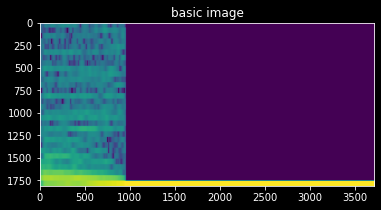

In [ ]:
# Viewing a MFCC and it's dimensions
img = cv2.imread('/virufy_mfccs/neg/neg-0421-083-cough-m-53-0.png', 0)

print(f"Saved image shape: {img.shape}")
plt.Figure(figsize=(12,6))
plt.title('basic image')
plt.imshow(img);

In [ ]:
# Splitting our preprocess image folder into train, test, and validation subfolders
# in a new directory
splitfolders.ratio(input='/virufy_mfccs', 
                    output='/viru_mfcc_ttv/', 
                    seed=42, ratio=(0.7, 0.1, 0.2)) # ratio of data sharing for
                                                    # train, test, val folders

Copying files: 121 files [00:00, 5603.77 files/s]


In [ ]:
vmfcc_train_folder, vmfcc_test_folder, vmfcc_val_folder = create_ttv('/viru_mfcc_ttv')

In [ ]:
# Defining our image size
IMG_SIZE = (200,400)

# Creating ImageDataGenerators for train and test/val
viru_mfcc_train_datagen = ImageDataGenerator(rescale=1./255, 
                                             brightness_range=(0.9, 1.2))

viru_mfcc_test_val_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
viru_mfcc_train_gen = viru_mfcc_train_datagen.flow_from_directory(vmfcc_train_folder, 
                                                        target_size=IMG_SIZE,
                                                        batch_size=32, 
                                                        class_mode='binary')
                                                        
viru_mfcc_test_gen = viru_mfcc_test_val_datagen.flow_from_directory(vmfcc_test_folder, 
                                                        target_size=IMG_SIZE,
                                                        batch_size=32, 
                                                        class_mode='binary', 
                                                        shuffle=False)

viru_mfcc_val_gen = viru_mfcc_test_val_datagen.flow_from_directory(vmfcc_val_folder,
                                                        target_size=IMG_SIZE,
                                                        batch_size=32, 
                                                        class_mode='binary')

Found 84 images belonging to 2 classes.
Found 26 images belonging to 2 classes.
Found 11 images belonging to 2 classes.


In [ ]:
class_weights_dict = make_class_weights(viru_mfcc_train_gen)
INPUT_SHAPE = viru_mfcc_train_gen.image_shape

{0: 0.8235294117647058, 1: 1.2727272727272727}


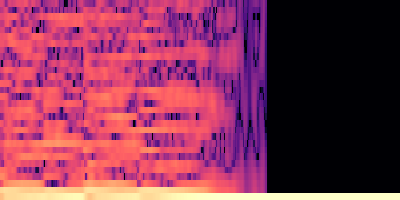

In [ ]:
ex_image = next(viru_mfcc_train_gen)[0][0]
array_to_img(ex_image)

In [ ]:
def viru_mfcc_model(shape='', opt=tf.keras.optimizers.Adam(), 
                        metrics=['acc', tf.keras.metrics.Precision(name='precision'),
                                        tf.keras.metrics.Recall(name='recall'), 
                                        tf.keras.metrics.AUC(name='auc')],
                        loss='binary_crossentropy', 
                        verbose=1):
  """
  Definition:
  Creates and compiles a neural network model. 

  Args:
  shape: default = ''. The input shape of the images to be passed in to the 
  neural network. The size must be the same as the images being passed in.
  metrics: default = ['acc', tf.keras.metrics.Precision(name='precision'),
                             tf.keras.metrics.Recall(name='recall'), 
                             tf.keras.metrics.AUC(name='auc')].
           The metrics that are to be analyzed and plotted from the 
           training of the model.
  verbose: default = 1. If 1, prints a summary of the model upon compilation.

  Returns:
  The model, along with the model.summary() if verbose = 1.
  """
  if len(shape) < 1:
    print('Please define input shape!')
  else:
    model = Sequential()
    model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=shape))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(64, (3,3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    # model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    # model.add(MaxPooling2D((2, 2)))

    # model.add(layers.Conv2D(256, (3, 3), activation='relu'))
    # model.add(MaxPooling2D((2, 2)))
    
    model.add(Flatten())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dropout(0.2))

    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.2))

    model.add(layers.Dense(128, activation='relu'))
    #model.add(layers.Dropout(0.2))

    model.add(layers.Dense(64, activation='relu'))

    model.add(layers.Dense(32, activation='relu'))

    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(loss=loss, optimizer=opt, metrics=metrics)
    if verbose:
      print(model.summary())
    return model

In [ ]:
vmfcc_model1 = viru_mfcc_model(INPUT_SHAPE, opt=tf.keras.optimizers.Adam(0.001, decay=0.0002))

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 198, 398, 32)      896       
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 99, 199, 32)       0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 97, 197, 64)       18496     
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 48, 98, 64)        0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 301056)            0         
_________________________________________________________________
dense_64 (Dense)             (None, 512)               154141184 
_________________________________________________________________
dropout_22 (Dropout)         (None, 512)             

Epoch 1/15
3/3 [==============================] - 11s 4s/step - loss: 2.0001 - acc: 0.4808 - precision: 0.4154 - recall: 0.6537 - auc: 0.5295 - val_loss: 0.7926 - val_acc: 0.6364 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.2321
Epoch 2/15
3/3 [==============================] - 9s 3s/step - loss: 1.1593 - acc: 0.5236 - precision: 0.2745 - recall: 0.2015 - auc: 0.4637 - val_loss: 0.6907 - val_acc: 0.6364 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4464
Epoch 3/15
3/3 [==============================] - 9s 3s/step - loss: 0.6950 - acc: 0.5234 - precision: 0.4419 - recall: 0.7041 - auc: 0.5782 - val_loss: 0.6879 - val_acc: 0.6364 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5000
Epoch 4/15
3/3 [==============================] - 9s 3s/step - loss: 0.6965 - acc: 0.5724 - precision: 0.4320 - recall: 0.4924 - auc: 0.5038 - val_loss: 0.6981 - val_acc: 0.3636 - val_precision: 0.3333 - val_recall: 0.7500 - val_auc: 0.5000
Epoch 5/15


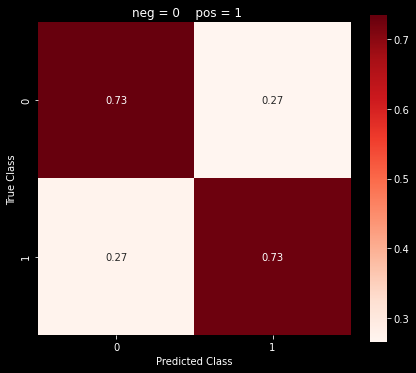

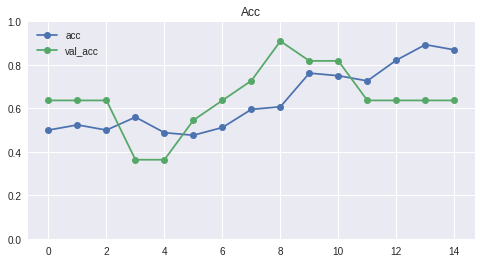

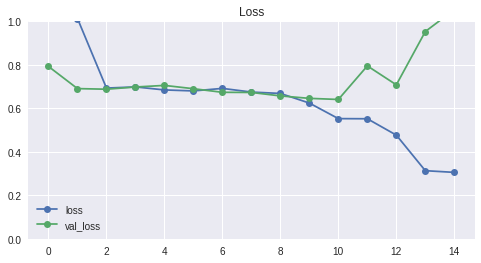

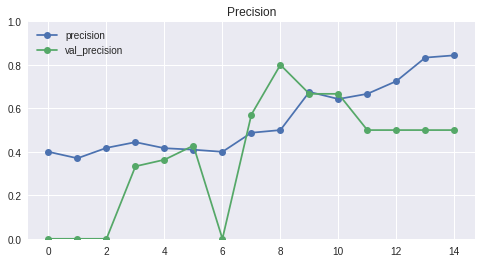

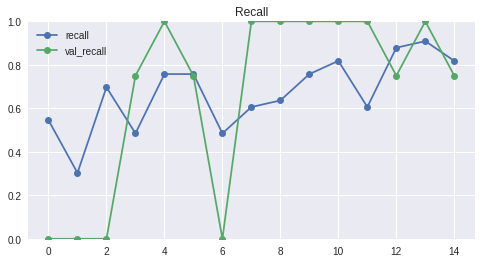

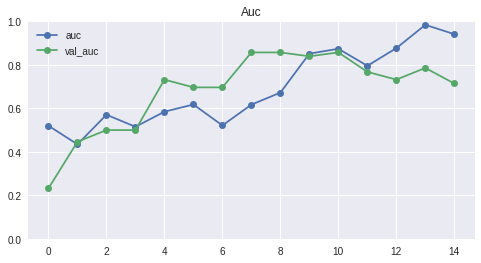

------------------------------------------------------------
1/1 [==============================] - 2s 2s/step - loss: 0.7596 - acc: 0.7308 - precision: 0.6667 - recall: 0.7273 - auc: 0.7364
loss score: 0.7596390247344971
accuracy score: 0.7307692170143127
precision score: 0.6666666865348816
recall score: 0.7272727489471436
auc score: 0.7363636493682861

Time to run cell: 148 seconds


In [ ]:
vmfcc_hist = fit_plot_report_gen(vmfcc_model1, viru_mfcc_train_gen, viru_mfcc_test_gen, 
                                 viru_mfcc_val_gen, class_weights=class_weights_dict, batch_size=32, 
                                 epochs=15)

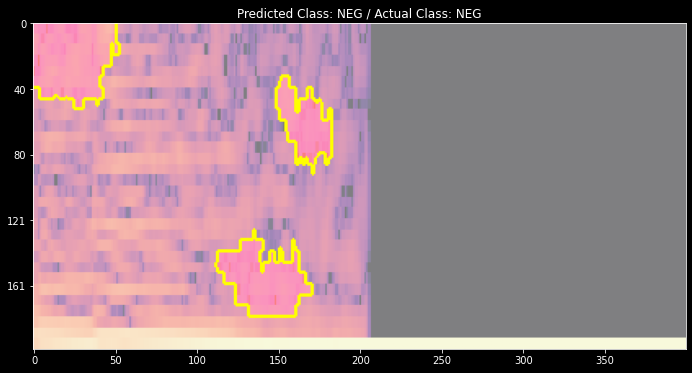

In [ ]:
explain_image(model=vmfcc_model1, generator=viru_mfcc_train_gen, figsize=(12,6))

#### Extending the length of audio data Playground

Since our first audio dataset consists of audio files with the exact length of 1.6 seconds, and our second dataset consists of audiofiles with a length of up to 10 seconds, we will need to fill in silent frames into our smaller audio files.

link: https://stackoverflow.com/questions/46757852/adding-silent-frame-to-wav-file-using-python

In [ ]:
# Address of example we are going to work with
target_audio

'/virufy_data-main/clinical/segmented/pos/pos-0421-094-cough-m-51-5.mp3'

In [ ]:
signal, sr = librosa.load(target_audio)
max_duration = 10 # in seconds
duration = librosa.get_duration(signal, sr)
print(duration)

1.5998639455782313


In [ ]:
silent_length = (max_duration*1000) - (duration*1000)
print(int(silent_length))

8400


In [ ]:
# creating 8.4 secs of audio silence -- duration in milliseconds
silent_segment = AudioSegment.silent(duration=silent_length)

In [ ]:
#read our target wav file example to an audio segment
cough_audio = AudioSegment.from_mp3(target_audio)

In [ ]:
# Combining our silent segment with the audio example
extended_cough = cough_audio + silent_segment

In [ ]:
# Viewing our extended_cough variable's type
type(extended_cough)

pydub.audio_segment.AudioSegment

In [ ]:
# making a folder to hold our extended audio example
os.makedirs('/ext_audio_test', exist_ok=True)

In [ ]:
extended_cough.export(out_f='/ext_audio_test/extended_cough2.mp3')

<_io.BufferedRandom name='/ext_audio_test/extended_cough2.mp3'>

In [ ]:
signal, sr = librosa.load('/ext_audio_test/extended_cough2.mp3', sr=22050)

In [ ]:
ipd.Audio(signal, rate=sr)

In [ ]:
# length of our extended audio file
duration = librosa.get_duration(signal, sr)
print(duration)

9.999863945578232


In [ ]:
shutil.rmtree('/ext_audio_test')

## End Test Area

## Obtaining CoughVid audio data

Again, we unzip the saved file stored in our Google Drive in order to access the CoughVid audio data. Note that CoughVid is a crowdsourced dataset, gathered from the CoughVid app, which can be found in the link below. This dataset contains over 20,000 different types of cough audio samples.

link to CoughVid app: https://coughvid.epfl.ch/

Unzipping folder containing the CoughVid dataset and audio files

In [ ]:
#os.path.dirname(FOLDER + 'public_dataset.zip')

'/content/drive/MyDrive/chris_lewis_capstone'

In [ ]:
# Extracting the contents of our coughvid zipped folder. Please make sure
# you've saved the shared folder at the top of the notebook to your Google Drive

# Making sure we are in the root directory
%cd ~
%cd .. 

# the zipped Coughvid file in your Google Drive
zipped_file= FOLDER + 'public_dataset.zip'

start = time.time()
with ZipFile(zipped_file,'r') as zip:
      zip.extractall()
      print('Successfully extracted CoughVid dataset')
end = time.time()
time_count(start, end)

/root
/
Done
Time to run cell: 18 seconds


In [ ]:
# Reading in the csv file into a dataframe
coughvid_df = pd.read_csv('/public_dataset/metadata_compiled.csv')

In [ ]:
coughvid_df.head()

,uuid,datetime,cough_detected,latitude,longitude,age,gender,respiratory_condition,fever_muscle_pain,status,quality_1,cough_type_1,dyspnea_1,wheezing_1,stridor_1,choking_1,congestion_1,nothing_1,diagnosis_1,severity_1,quality_2,cough_type_2,dyspnea_2,wheezing_2,stridor_2,choking_2,congestion_2,nothing_2,diagnosis_2,severity_2,quality_3,dyspnea_3,wheezing_3,stridor_3,choking_3,congestion_3,nothing_3,cough_type_3,diagnosis_3,severity_3
0,00039425-7f3a-42aa-ac13-834aaa2b6b92,2020-04-13T21:30:59.801831+00:00,0.9609,31.3,34.8,15.0,male,False,False,healthy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0009eb28-d8be-4dc1-92bb-907e53bc5c7a,2020-04-12T04:02:18.159383+00:00,0.9301,40.0,-75.1,34.0,male,True,False,healthy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0012c608-33d0-4ef7-bde3-75a0b1a0024e,2020-04-15T01:03:59.029326+00:00,0.0482,-16.5,-71.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,001328dc-ea5d-4847-9ccf-c5aa2a3f2d0f,2020-04-13T22:23:06.997578+00:00,0.9968,NaN,NaN,21.0,male,False,False,healthy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,001c85a8-cc4d-4921-9297-848be52d4715,2020-04-17T15:24:35.822355+00:00,0.0735,40.6,-3.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


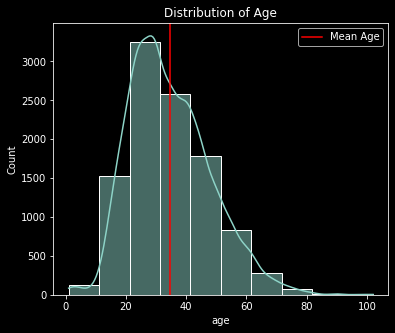

In [ ]:
# Viewing the distribution of age in coughvid dataset
fig, ax = plt.subplots(figsize=(6, 5))
sns.histplot(data=coughvid_df, x='age', bins=10, kde=True)
plt.axvline(x=coughvid_df['age'].mean(), c = 'r', label='Mean Age')
plt.title('Distribution of Age')
plt.legend()
plt.show()

Distribution of age seems to be relatively normal, with a slight skew to the right.

### Column information

>- **uuid**: The address of the associated audio and json file for a patient.
- **datetime**: Timestamp of the received recording in ISO 8601
format.
- **cough_detected**: Probability that the recording contains cough sounds, according to the automatic detection algorithm
that was used by Orlandic et al.
- **latitude**: Self-reported latitude geolocation coordinate with reduced precision.
- **longitude**: Self-reported longitude geolocation coordinate with reduced precision.
- **age**: Self-reported age value.
- **gender**: Self-reported gender.
- **respiratory_condition**: If the patient has other respiratory conditions (self-reported).
- **fever_muscle_pain**: If the patient has a fever or muscle pain (self-reported).
- **status**: The patient self-reports that has been diagnosed with COVID-19 (COVID), that has symptoms but no diagnosis (symptomatic), or that is healthy (healthy).

>Within the next set of columns, it is important to know that 3 expert pulmonologists were each assigned with revising 1000 recordings to enhance the quality of the dataset with clinically validated information. They selected one of the predefined options to each of the following 10 items:



>**Categorical Columns**:
- **quality**: quality of the recorded cough sound.
  - values: {good, ok, poor, no_cough} 
- **cough_type**: Type of the cough.
  - values:  {wet, dry, unknown}
- **diagnosis**: Impression of the expert about the condition of the patient. It can be an upper or lower respiratory tract
infection, an obstructive disease (Asthma, COPD, etc), COVID-19, or a healthy cough.
  - values: {upper_infection, lower_infection, obstructive_disease, COVID-19, healthy_cough}
- **severity**: Impression of the expert about the severity of the cough. It can be a pseudocough from a healthy patient, a mild or severe cough from a sick patient, or unknown if the expert can’t tell.
  - values: {pseudocough, mild, severe, unknown}

>**Boolean Columns**:
- **dyspnea**: Presence of any audible dyspnea.
- **wheezing**: Presence of any audible wheezing.
- **stridor**: Presence of any audible stridor.
- **choking**: Presence of any audible choking.
- **congestion**: Presence of any audible nasal congestion.
- **nothing**: Nothing specific is audible.


In [ ]:
print("Percent of null values for each column:")
for col in coughvid_df.columns:
  print(f"{col}: {round(coughvid_df[col].isna().sum()/len(coughvid_df), 3)}")

Percent of null values for each column:
uuid: 0.0
datetime: 0.0
cough_detected: 0.0
latitude: 0.415
longitude: 0.415
age: 0.478
gender: 0.436
respiratory_condition: 0.436
fever_muscle_pain: 0.436
status: 0.436
quality_1: 0.959
cough_type_1: 0.959
dyspnea_1: 0.959
wheezing_1: 0.959
stridor_1: 0.959
choking_1: 0.959
congestion_1: 0.959
nothing_1: 0.959
diagnosis_1: 0.959
severity_1: 0.959
quality_2: 0.959
cough_type_2: 0.959
dyspnea_2: 0.959
wheezing_2: 0.959
stridor_2: 0.959
choking_2: 0.959
congestion_2: 0.959
nothing_2: 0.959
diagnosis_2: 0.959
severity_2: 0.959
quality_3: 0.959
dyspnea_3: 0.959
wheezing_3: 0.959
stridor_3: 0.959
choking_3: 0.959
congestion_3: 0.959
nothing_3: 0.959
cough_type_3: 0.96
diagnosis_3: 0.96
severity_3: 0.96


We see that the majority of our data have missing values in the expert columns. This is expected because they each reviewed only 1000 audio files, therefore the majority of these values should be missing. Also note that about 15% of the recordings were labeled by all three reviewers, so that Orlandic et al. could assess the level of agreement among the pulmonologists.


In [ ]:
# Dataframe containing rows that were reviewed by one or more pulmonologist
expert_df = coughvid_df[(coughvid_df['quality_1'].notnull()) | 
                        (coughvid_df['quality_2'].notnull()) | 
                        (coughvid_df['quality_3'].notnull())]

In [ ]:
len(expert_df)

2200

In [ ]:
expert_df.head()

,uuid,datetime,cough_detected,latitude,longitude,age,gender,respiratory_condition,fever_muscle_pain,status,quality_1,cough_type_1,dyspnea_1,wheezing_1,stridor_1,choking_1,congestion_1,nothing_1,diagnosis_1,severity_1,quality_2,cough_type_2,dyspnea_2,wheezing_2,stridor_2,choking_2,congestion_2,nothing_2,diagnosis_2,severity_2,quality_3,dyspnea_3,wheezing_3,stridor_3,choking_3,congestion_3,nothing_3,cough_type_3,diagnosis_3,severity_3
11,002db0bd-e57f-4c30-ade0-16640d424eb7,2020-04-13T19:51:11.397697+00:00,0.9536,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,good,False,False,False,False,False,True,unknown,healthy_cough,pseudocough
27,005b8518-03ba-4bf5-86d2-005541442357,2020-04-14T20:16:53.677536+00:00,0.9854,45.2,19.7,23.0,female,False,False,healthy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,good,dry,False,False,False,False,False,True,lower_infection,mild,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
34,006d8d1c-2bf6-46a6-8ef2-1823898a4733,2020-04-22T10:24:21.408615+00:00,0.2677,NaN,NaN,28.0,male,True,True,symptomatic,ok,dry,False,False,False,False,False,True,healthy_cough,pseudocough,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47,008ba489-31ad-44d8-856b-fcf72369dc46,2020-04-13T23:09:36.585124+00:00,0.9962,38.1,-122.2,28.0,female,False,False,healthy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,good,False,False,True,False,False,False,wet,lower_infection,mild
48,008c1c9e-aeef-40c5-846c-24f1b964f884,2020-04-12T21:25:00.131353+00:00,0.9751,48.9,2.7,44.0,male,False,False,symptomatic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,good,False,False,False,False,False,True,wet,healthy_cough,pseudocough


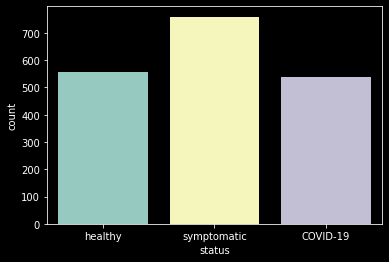

In [ ]:
sns.countplot(data=expert_df, x='status')

In [ ]:
# expert_df = pd.read_csv('/content/drive/MyDrive/gdrive/capstone/created_dfs/expert_df.csv')
# expert_df.drop('Unnamed: 0', axis=1, inplace=True)

Our Reasoning for setting the threshold of cough_detection >= 0.8:

According to Orlandic et al., "the ROC curve of the cough classifier is displayed below, which users of the COUGHVID database can consult to set a cough detection threshold that suits their specifications. As this figure shows, only 10.4% of recordings with a cough_detected value less than 0.8 actually contain cough sounds. Therefore, they should be used only for robustness assessment, and not as valid cough examples."


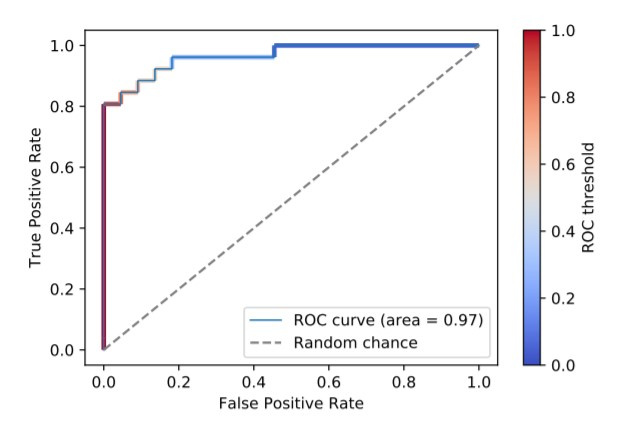

Figure from: Lara Orlandic, Tomas Teijeiro, & David Atienza. (2021). The COUGHVID crowdsourcing dataset: A corpus for the study of large-scale cough analysis algorithms (Version 2.0) [Data set]. Zenodo. http://doi.org/10.5281/zenodo.4498364

In [ ]:
# Setting the threshold of cough detection needing to be 80% or greater
cough_df = coughvid_df[coughvid_df['cough_detected'] >= 0.8]

In [ ]:
# We've cut our dataset in half, but since we are focused on training a model to 
# detect COVID-19 through coughing audio, we must make sure that we feed it the 
# audio that actually contains coughing.

len(cough_df)

10746

In [ ]:
# Making sure there are no duplicates in our UUID column
cough_df['uuid'].nunique()

10746

The values within the 'status' column:

The patient self-reports that have been diagnosed with COVID-19 (COVID), that has symptoms but no diagnosis (symptomatic), or that is healthy (healthy).


In [ ]:
# Inspecting counts of each value in 'status' column
cough_df['status'].value_counts()

healthy        5628
symptomatic    1135
COVID-19        547
Name: status, dtype: int64

In [ ]:
# Inspecting count of null values within our 'status' column
cough_df['status'].isna().sum()

3436

In [ ]:
# Checking the quality of the coughing audio labeled by each expert
quality_check = ['quality_1', 'quality_2', 'quality_3']
for col in quality_check:
  print(f"{cough_df[col].value_counts()}\n")


ok          504
poor        127
good         30
no_cough      7
Name: quality_1, dtype: int64

good        391
ok          229
poor         52
no_cough      6
Name: quality_2, dtype: int64

good        625
ok           21
poor          9
no_cough      8
Name: quality_3, dtype: int64



Breaking down the DataFrame into [healthy, COVID] sub dfs

In [ ]:
# dataframe containing all information for those diagnosed as 'healthy'
healthy_df = cough_df[cough_df['status'] == 'healthy']

In [ ]:
# dataframe containing all information for those diagnosed as having 'COVID-19'
covid_df = cough_df[cough_df['status'] == 'COVID-19']

In [ ]:
# Defining a function to remove any rows where quality of the audio indicates 
# there is no cough present in the audio according the to expert pulmonologists

def quality_scrub(df, target_cols = ['quality_1', 'quality_2', 'quality_3']):
  for col in target_cols:
    df = df[df[col] != 'no_cough']
  return df

In [ ]:
# Our cleaned version of the covid_df and the healthy_df
new_covid_df = quality_scrub(covid_df)
new_healthy_df = quality_scrub(healthy_df)

In [ ]:
# Viewing the number of rows that were dropped in the covid_df
print(f"Comparing scrubbed covid df length to original:\n"
      f"Original: {len(covid_df)}, Scrubbed: {len(new_covid_df)}\n\n"
      f"Comparing scrubbed healthy df to original:\n"
      f"Original: {len(healthy_df)}, Scrubbed: {len(new_healthy_df)}")

Comparing scrubbed covid df length to original:
Original: 547, Scrubbed: 539

Comparing scrubbed healthy df to original:
Original: 5628, Scrubbed: 5626


### Moving all audio files into new directory

Since the unzipped public dataset not only contains our desired audio files, but also related .json files and a .csv file, we are going to move the audio files into a new directory so we don't have to worry about any other files while working with the audio files.

In [ ]:
# Set a filepath where you want to store the audio from the coughvid dataset in
# the 'all_cv_audio' variable. This is a temporary file, I recommend storing it in the 
# root directory.
all_cv_audio = ensure_filepath('/public_dataset_audio')

start = time.time()

# Copying files from /public_dataset and adding them to /public_audio_dataset
shutil.copytree('/public_dataset', all_cv_audio, 
                # Ignoring any csv and json files
                ignore = shutil.ignore_patterns('*.csv', '*.json'))

end = time.time()
time_count(start, end)

Time to run cell: 9 seconds


In [ ]:
# removing the original public dataset file
try:
  shutil.rmtree('/public_dataset')
except:
  pass

In [ ]:
# Making sure we have copied the correct number of files 
# Should be the same number as our coughvid_df 
print(len(os.listdir(all_cv_audio)))
len(os.listdir(all_cv_audio)) == len(coughvid_df)

20072


True

In [ ]:
# Making sure all files brought over from the public dataset are either webm or
# ogg files. Viewing proportions of each file type

filetype_dict = {'webm': 0, 'ogg': 0}
for item in os.listdir(all_cv_audio):
  item_type = item[-4:]
  if 'webm' in item_type:
    filetype_dict['webm'] += 1
  if 'ogg' in item_type:
    filetype_dict['ogg'] += 1
print(filetype_dict)

{'webm': 19213, 'ogg': 859}


### Separating healthy and covid audio via separate directories

Putting all public_dataset covid audio files into separate directory

In [ ]:
# Remember that this is the scrubbed version of our covid patients
len(new_covid_df)

539

In [ ]:
def move_audio_files(df, target_col, source, dest, filetypes=['.webm', '.ogg']):
  """
  Definition:
  Provide a dataframe and target column as a unique identifier for files stored
  in the source folder. The function will move all files that match the variables
  within the target column and move them to a new destination folder.

  Args:
  df: Required. A dataframe containing a unique column identifier for files
  target_col: Required. The unique identifier used to select certain files from
  the source folder.
  source: Required. The folder containing the files we want to filter based on the
  target_col
  dest: Required. The file destination we want to copy the filtered files to.
  filetypes: default = ['.webm', '.ogg']. The types of files within the source 
  folder we are targeting.

  Returns:
  Makes a copy of the filtered files in the new destination folder.
  """
  
  start = time.time()
  # Creating new destination
  os.makedirs(dest, exist_ok=True) 
  # For each item in our target column: 
  for uuid in df[target_col]:
    # the source id equals the source variable + the item
    src = source + uuid
    try:
      # try to copy the file to the destination if it is a .webm file
      shutil.copy(src=src + filetypes[0], dst=dest)
    except:
      # If that doesn't work
      try:
        # Try to copy the file to the destination if it is an .ogg file
        shutil.copy(src=src + filetypes[1], dst=dest)
      except:
        # If that doesn't work, skip it and continue
        continue
  end = time.time()
  time_count(start, end)

In [ ]:
# Moving our 'pos' case audio files into a new folder
# Please set a filepath where you would like to store the target audio files 
# where cough probability in those files is 80% or greater in the 'cv_audio' 
# variable
cv_audio = ensure_filepath('/cv_audio/')

move_audio_files(df=new_covid_df, target_col='uuid', source=all_cv_audio, 
                dest=cv_audio + 'pos')

Time to run cell: 0 seconds


In [ ]:
# Checking to make sure we have the same length as our dataframe
print(len(new_covid_df) == len(os.listdir(cv_audio + 'pos')))
# Printing the amount of audio files in our newly created folder
print(f"Amount of audio in 'pos' subfolder: {len(os.listdir(cv_audio + 'pos'))}")

True
Amount of audio in 'pos' subfolder: 539


Putting all public_dataset healthy audio files into separate directory

In [ ]:
move_audio_files(df=new_healthy_df, target_col='uuid', source=all_cv_audio, 
                 dest=cv_audio + 'neg')

Time to run cell: 1 seconds


In [ ]:
print(len(new_healthy_df) == len(os.listdir(cv_audio + 'neg')))
# Printing the amount of audio files in our newly created folder
print(f"Amount of audio in 'neg' subfolder: {len(os.listdir(cv_audio + 'neg'))}")

True
Amount of audio in 'neg' subfolder: 5626


In [ ]:
# Removing our previous folder since we don't need to work with it anymore
try:
  shutil.rmtree(all_cv_audio)
except:
  pass

### Converting .webm audio to .ogg audio

webm files are actually video files. In order for us to be able to extract the audio from these files, we need to find a library that can help us do so.



Converting all webm audio files into ogg files

In [ ]:
def convert_audio(root_dir, new_dir):
  """
  Definition:
  For every item in the root directory, this func identifies the type of audio 
  file. If the audio file is a .webm file, the function uses the library ffmpeg
  to change the file type into an .ogg file and transfers that new file into 
  the new specified directory.

  Args:
  root_dir: Required. Declare the directory that holds the targeted files you wish
  to convert.
  new_dir: Required. Declare the new directory you wish to store the converted
  files. Does not have to exist beforehand.

  Returns:
  Creates the new directory, stores the converted files, and prints the amount 
  of time it took to run the function.
  """
  start = time.time()

  for status in os.listdir(root_dir):
    root_address = root_dir + status + '/'
    new_address = new_dir + status + '/'
    os.makedirs(new_address, exist_ok=True)

    for audio in tqdm(os.listdir(root_address), desc=status):
      extension = os.path.splitext(audio)[-1].lower()

      if extension == '.webm':
        audio_name = os.path.splitext(audio)[0]
        input = f"ffmpeg -i {root_address + audio_name}.webm {new_address + audio_name}.ogg"
        os.system(input)

      else:
        shutil.copy(src=root_address+audio, dst=new_address)

  end = time.time()
  time_count(start, end)  

In [ ]:
# Define a base folder to store .webm-to-.ogg converted audio files
cleaned_audio = ensure_filepath('/cleaned_audio/')

In [ ]:
convert_audio(cv_audio, cleaned_audio)

pos: 100%|██████████| 539/539 [02:11<00:00,  4.09it/s]

Time to run cell: 1433 seconds


In [ ]:
# Sanity check
for folder in os.listdir(cleaned_audio):
  print(len(os.listdir(cleaned_audio + folder)))

5626
539


In [ ]:
# Removing the folder containing the old audio files
try:
  shutil.rmtree(cv_audio)
except:
  pass

In [ ]:
# Please define a filepath where you would like to store the converted audio files
# if you would like to save to Google Drive. I HIGHLY RECOMMEND
# saving a copy of the cleaned audio to you Google Drive

# example filepath: /content/drive/MyDrive/gdrive/capstone/audio_folders/cleaned_audio/

ans = input('Would you like to save the cleaned_audio to a permanent folder? [y][n] ')
if ans.lower() == 'y':
  fpath = input('Please provide a filepath to store the data: ')
  fpath = ensure_filepath(fpath)
  try:
    shutil.copytree(cleaned_audio, fpath)
    print(f'Successfully saved data to {fpath}')
  except:
    print('Could not save the data. Please try again.')
else:
  print('Did not save the data')

Would you like to save the cleaned_audio to a permanent folder? [y][n] n
Did not save the data


In [ ]:
# Sanity check
try:
  for folder in os.listdir(fpath):
    print(len(os.listdir(fpath + folder)))
except:
  print('Did not save cleaned audio to storage.')

5626
539


### Finding the duration of our CoughVid audio Files

In [ ]:
def get_audio_duration(root_dir):
  """
  Definition:
  Finds the duration of each audio file in a folder, uses the librosa library to
  get the time duration for each file, and appends each duration to a list called 
  duration_list. This list is then transformed into a dataframe, and then returned
  and the function output.

  Args:
  root_dir: Required. Specify the folder that holds the audio files.

  Returns:
  A dataframe that holds the duration for each audio file and prints the amount
  of time it took to run the function.
  """
  
  duration_list = []
  start = time.time()

  for status in os.listdir(root_dir):
    address = root_dir + status + '/'
    for audiofile in tqdm(os.listdir(address), desc=status):
      try:
        # setting the variable audio_time and giving it the duration of the file
        audio_time = librosa.get_duration(filename=address+audiofile)
        # appending the audio_time variable to our list
        duration_list.append(audio_time)
      except:
        # Adding 0 if we can't extract the duration. We should not get any zeros
        duration_list.append(0)

  df = pd.Series(duration_list, name='duration').to_frame()

  end = time.time()
  time_count(start, end)
  return df

In [ ]:
# If you choose to run this cell, it will take a considerable amount of time
# Make sure that your connection to the kernel does not time out while this cell
# is running.

ans = input(f'WARNING: This cell will take over an hour to run. '
            f'Retrieve the duration of the audio files? [y][n] ')
if ans.lower() == 'y':
  duration_df = get_audio_duration(cleaned_audio)
  duration_df['duration'].describe()

In [ ]:
# If you want to save the dataframe to a folder, please answer 'y' and set a filepath
# for the dataframe to be saved in.

# example filepath: /content/drive/MyDrive/gdrive/capstone/created_dfs

try:
  duration_df
  ans = input("Would you like to save the created duration dataframe? [y][n] ")
  if ans.lower() == 'y':
    fpath = input('Please provide a filepath to store the data: ')
    fpath = ensure_filepath(fpath)
    try:
      duration_df.to_csv(fpath + 'duration.csv')
      print(f'Successfully saved the dataframe to {fpath}')
    except:
      print('Did not save a dataframe. Please try again.')
except:
  pass
      

Would you like to save the created duration dataframe? [y][n] y
Please provide a filepath to store the data: /test_df/
Successfully saved the dataframe to /test_df/


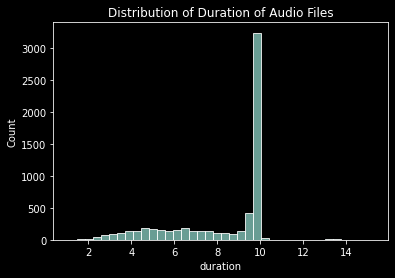

In [ ]:
# We've ran the above functioning cell and sved it in our google drive so we can
# load it in instead of running the cell above every time we want to view the data.

# Please load in the location of you Duration dataframe in the 'dur_df_path' variable
# If you chose to save a dataframe in the previous cells. Otherwise, omit this cell
try:
  dur_df_path = fpath + 'duration.csv'
  duration_df = pd.read_csv(dur_df_path)

  sns.histplot(duration_df, x='duration')
  plt.title('Distribution of Duration of Audio Files')
  plt.show()
except:
  print('No dataframe was passed in.')

Here we can see that the duration for all our our audio in the 'cleaned_audio' folder is not uniform. Just like images, we need to feed the model the same shape for audio files as well. To do this, we must add silence to audio files that are less than 10.02 seconds (our 99th percentile) and make them all 10.02 seconds long. After that, we may then proceed to make spectrogram images from each audio file once they are all the correct length. 

### Adding Silent length to Cleaned CV audio

Adding silent length to our audio files less than our max_duration (defined below) in the '/cleaned_audio/pos' folder

In [ ]:
def create_silence(root_dir, new_dir, max_dur=10.02):
  """
  Definition:
  Adds silence to each audio file in the specified root directory if the audio 
  file is shorter in length (in seconds) than the 'max_dur' variable. The extended
  audio files are then saved in the 'new_dir' address.

  Args:
  root_dir: Required. The directory that holds the audio files.
  new_dir: Required. The location the extended audio files will be saved to.
  max_dur: default = 10.02. The maximum duration for the audio files to be. If an
  audio file is longer than the maximum duration, the audio file will be skipped
  and not saved into the new directory.

  Returns:
  Saves the extended audio files to the new directory. Prints the time it took 
  to run the function.
  """
  
  start = time.time()

  for status in os.listdir(root_dir):
    root_address = root_dir + status + '/'
    new_address = new_dir + status + '/'
    os.makedirs(new_address, exist_ok=True)

    for audio in tqdm(os.listdir(root_address), desc=status):
      address = root_address + audio
      sig, sr = librosa.load(address)

      dur = librosa.get_duration(sig, sr=sr)
      if dur <= max_dur: 
        # Defining the amount of silence for each audio file
        silent_length = (max_dur*1000) - (dur*1000)
        silent_int = int(silent_length)

        # creating 8.4 secs of audio silence -- duration in milliseconds
        silent_segment = AudioSegment.silent(duration=silent_int)

        # Finding the extension for each file
        extension = os.path.splitext(audio)[-1].lower()

        if extension == '.mp3':
          cough_audio = AudioSegment.from_mp3(address)

        elif extension == '.ogg':
          cough_audio = AudioSegment.from_ogg(address)

        # Combining our silent segment with the audio example
        extended_cough = cough_audio + silent_segment

        # making a folder to hold our extended audio example
        output = f"{new_address + audio}" 
        #print(f"{output}\n")
        extended_cough.export(out_f=output)
      else: 
        continue

  end = time.time()
  time_count(start, end)

### Extending length of virufy audio

Extending all audio in virufy folder

In [ ]:
# Please specify where to save the extended Virufy audio. This folder is a 
# temporary folder to store the audio.

# example filepath: /ext_audio_virufy/

fpath = input('Please specify where to save extended Virufy Audio: ')
ext_audio_virufy = ensure_filepath(fpath)
create_silence(root_dir=virufy_base + 'segmented/', new_dir=ext_audio_virufy)

Please specify where to save extended Virufy Audio: /ext_audio_virufy/


pos: 100%|██████████| 48/48 [00:25<00:00,  1.86it/s]

Time to run cell: 65 seconds


In [ ]:
virufy_dur_df = get_audio_duration(ext_audio_virufy)
virufy_dur_df['duration'].describe()

pos: 100%|██████████| 48/48 [00:14<00:00,  3.40it/s]

Time to run cell: 35 seconds


count    121.0
mean      10.0
std        0.0
min       10.0
25%       10.0
50%       10.0
75%       10.0
max       10.0
Name: duration, dtype: float64

 Creating new silenced audio files from our 'cleaned_audio' folder and saving them into a new folder


In [ ]:
# Sending coughvid extended audio to our new_dir. Please specify where you would
# like to save the extended audio in the 'ext_audio' variable

# example filepath: /ext_audio/

ans = input('WARNING: This cell will take over an hour to run. Proceed? [y][n] ')
if ans.lower() == 'y':
  fpath = input('Please provide a filepath to saved the extended CoughVid audio files: ')
  ext_audio = ensure_filepath(fpath)
  create_silence(root_dir=cleaned_audio, new_dir=ext_audio)
else:
  print('Did not run')

Please provide a filepath to saved the extended CoughVid audio files: /ext_audio/


pos: 100%|██████████| 539/539 [05:39<00:00,  1.59it/s]

Time to run cell: 3886 seconds


## Recommendation:
- if you are working with audio files, it is extremely important to make sure the files are equal in time duration. I recommend finding the audio file with the longest time duration and zero padding audio files that are shorter than that maximum duration. This way, when you create the spectrogram images, you will ensure that they are all the same dimension along the x-axis (time). 

- However, we should be sure that our longest audio file is not an outlier. A way around that would be to find the 99th percentile of the time durations and define that value as the maximum value for all audio files.


Checking the number of files in our folder. Note that not all the audio files
will be moved to the folder. Audio files that are larger than 10.02 seconds will
not be added to our extended audio folders.

In [ ]:
# Viewing the number of extended audio files
for folder in os.listdir(ext_audio):
  print(f"{folder}: {len(os.listdir(ext_audio + folder))}")

neg: 5595
pos: 536


In [ ]:
# Removing folder containing unextended audio files
try:
  shutil.rmtree(cleaned_audio)
except:
  pass

### Combining the Virufy Extended Audio to the CoughVid Extended Audio

In [ ]:
# Joining extended virufy audio with coughvid audio into the 'ext_audio' folder
for folder in os.listdir(ext_audio_virufy):
  virufy_address = ext_audio_virufy + folder + '/'
  new_address = ext_audio + folder + '/'

  for audio in os.listdir(virufy_address):
    audio_file = virufy_address + audio
    try:
      shutil.move(audio_file, new_address)
    except:
      continue

In [ ]:
# Making sure our audio was combined
for folder in os.listdir(ext_audio):
  print(f"{folder}: {len(os.listdir(ext_audio + folder))}")

neg: 5668
pos: 584


In [ ]:
shutil.copytree(ext_audio, '/ext_audio_copy/')

'/ext_audio_copy/'

### Saving Combined Extended Audio 

Do not change any variables in the next four cells

In [ ]:
try:
  shutil.make_archive(base_name='ext_audio', format='zip', root_dir=ext_audio)
  print(f"zipped file successfully stored to  ext_audio.zip")
except:
  print('Save canceled')

zipped file successfully stored to  ext_audio.zip


In [ ]:
fpath = input(f"Please provide a filepath to store the compressed extended"
                    f" audio files: ")
fpath = ensure_filepath(fpath)
try:
  shutil.move('/ext_audio.zip', fpath + 'ext_audio.zip')
  print("Successfully move zipped file")
except:
  print('Could not move file. Please try again')

Please provide a filepath to store the compressed extended audio files: /content/drive/MyDrive/gdrive/capstone
Successfully move zipped file


### Loading in compressed extended audio
Now we can start from here since we've saved a zipped of our polished audio data

In [ ]:
with ZipFile(fpath +'ext_audio.zip', 'r') as zipf:
      zipf.extractall('/saved_ext_audio/')
      print('Done')

Done


In [ ]:
# Removing other audio files
try:
  saved_ext_audio = '/saved_ext_audio/'
  shutil.rmtree(ext_audio)
  shutil.rmtree(ext_audio_virufy)
except:
  pass

Now that we have saved our extended audio files, we will create mel-spectrogram images.

In [ ]:
# Sanity check
for folder in os.listdir(saved_ext_audio):
  print(f"{folder}: {len(os.listdir(saved_ext_audio + folder))}")

neg: 5668
pos: 584


### Creating Mel-Spectrograms

In [ ]:
def create_save_spectros(root_dir, new_dir, hop_length, n_fft, sr=22050,
                         fmax=9000, ref=1, figsize=(10, 4), cmap='magma', 
                         dpi=400, vmin=None, vmax=None):
  """
  Definition:
  Takes the address defined by the variable 'root_dir' and goes through each class
  folder within that directory. For each audio file in a class directory, the 
  librosa library loads the audio file into signal and sample rate variables, then 
  plots the mel-spectrogram. We then save the spectrogram into the address of the 
  'new_dir' folder using the same end name of the audio's original address, and 
  shuts down the figure.

  Args:
  root_dir: Required. The address containing subfolders of classes and audio 
  files within those folders.
  new_dir: Required. The address you wish to save the mel-spectrograms.
  hop_length: Required. The number of samples between successive frames - 
  (e.g. the columns of a spectrogram)
  n_fft: Required. The (positive integer) number of samples in an analysis 
  window (or frame). Should be larger than hop_length.
  sr: default = 22050. The (positive integer) number of samples per second of a 
  time series.
  fmax: default = 9000. Highest frequency (in Hz).
  ref: default = 1. If scalar, the amplitude abs(S) is scaled relative to 'ref'.
  figsize: default = (10, 4). The size of the plotted spectrogram.
  cmap: default = 'magma'. The color palette of the spectrogram.
  dpi: default = 400. The resolution in dots per inch - higher values result in
  higher quality images.

  Returns:
  The time it took to run the function in seconds.
  """
  start = time.time()
  #making sure we add a forward slash to our root_dir and new_dir variables

  # For each subfolder in our root directory:
  for status in os.listdir(root_dir):

    # Create a new variable called subfolder
    subfolder = root_dir + status

    # For each audio file in our subfolder, load into signal and sample rate vars
    for audiofile in tqdm(os.listdir(subfolder), desc=status):
      signal, sr = librosa.load(subfolder + '/' + audiofile, sr=sr)

      plt.interactive(False)

      # Creating a melspectrogram
      if (vmin != None) and (vmax != None):
        mel_signal = librosa.feature.melspectrogram(y=signal, sr=sr, 
                                                    hop_length=hop_length, 
                                                    n_fft=n_fft, fmax=fmax, 
                                                    vmin=vmin, vmax=vmax)
      

      else:
        mel_signal = librosa.feature.melspectrogram(y=signal, sr=sr, 
                                                    hop_length=hop_length, 
                                                    n_fft=n_fft, fmax=fmax)
        
      # Converting the power in the ndarray of our mel_signal into decibels
      power_to_db = librosa.power_to_db(mel_signal, ref=ref)
      # Creating figure
      fig = plt.figure(figsize=figsize)
      ax = fig.add_subplot(111)
      # Hiding axes and image frame
      ax.axes.get_xaxis().set_visible(False)
      ax.axes.get_yaxis().set_visible(False)
      ax.set_frame_on(False)

      # Displaying our spectrograms
      ldp.specshow(power_to_db, sr=sr, cmap=cmap, hop_length=hop_length)
      
      # making folder to store images
      new_subfolder = new_dir + status + '/'
      os.makedirs(new_subfolder, exist_ok=True)

      #print(new_subfolder)

      # Saving each spectrogram into its respective folder
      # subfile[:-4] is a string of the subfile without the ending extension '.mp3'
      # We add the '.png' extension to the end of our new spectrogram images instead
      plt.savefig(fname=new_subfolder + audiofile[:-4] + '.png', dpi=dpi, 
                  bbox_inches='tight',pad_inches=0)
      
      # We then manually close pyplot, clear the figure, close the fig variable, 
      # and then close the figure window
      plt.close()    
      fig.clf()
      plt.close(fig)
      plt.close('all')

  # Display the time it took to run the cell in seconds
  end = time.time()
  time_count(start, end)

Creating our spectrograms and saving them in a new folder

In [ ]:
# Please set a filepath to save the spectrograms in the 'spec_dir' variable.
# This cell will take a considerable amount of time. I recommend making a copy
# of the saved folder containing the extended audio files and placing the copy
# in the root directory so google colab can access the files quicker. I also
# recommend saving the spectrograms in a filepath also located in the root directory

# example filepath = /content/drive/MyDrive/gdrive/capstone/spectrograms/

ans = input('WARNING: This cell will take over an hour to run. Proceed? [y][n] ')
if ans.lower() == 'y':
  fpath = input(f"Please specify what folder you would like to save the spectrogram"
                f" images in: ")
  fpath = ensure_filepath(fpath)

  create_save_spectros(root_dir=saved_ext_audio, new_dir=fpath, hop_length=512, 
                      n_fft=2048, fmax=9000, ref=np.max, figsize=(10, 4))

Please specify what folder you would like to save the spectrogram images in: /spectro_images


pos: 100%|██████████| 584/584 [12:54<00:00,  1.33s/it]

Time to run cell: 8275 seconds


Viewing a saved spectrogram and its dimensions

Saved image shape: (1208, 3100)


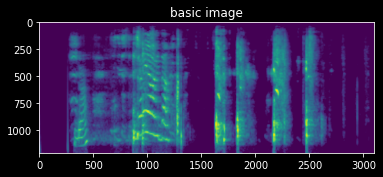

In [ ]:
spec_root = fpath + 'pos/'
spec_ex = os.listdir(spec_root)[0]
img = cv2.imread(spec_root + spec_ex, 0)

print(f"Saved image shape: {img.shape}")
plt.title('basic image')
plt.imshow(img);

(200, 500, 3)


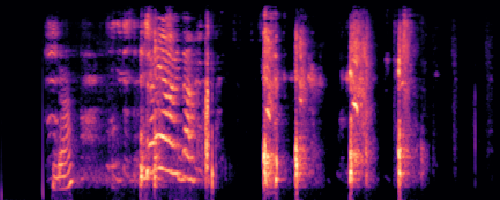

In [ ]:
# Note that we can change the size of our images by using the load_img() function
img_ex = load_img(spec_root + spec_ex, target_size=(200, 500))
print(img_to_array(img_ex).shape)
img_ex

In [ ]:
# Viewing number of spectrograms in our permanent folder
spectro_images = num_items(fpath, targets=['pos', 'neg'])

/spectro_images/
Number of items in pos: 584
Number of items in neg: 5668
Total number of items: 6252


### Saving & Loading Spectrogram images

In [ ]:
# Zipping the newly created spectrograms folder
try:
  shutil.make_archive(base_name='spectro_images', format='zip', root_dir=fpath)
  print(f"zipped file successfully stored to  spectro_images.zip")
except:
  print('Save canceled')

zipped file successfully stored to  spectro_images.zip


In [ ]:
fpath = input(f"Please provide a filepath to store the compressed spectrograms: ")
fpath = ensure_filepath(fpath)
try:
  shutil.move('/spectro_images.zip', fpath + 'spectro_images.zip')
  print("Successfully move zipped file")
except:
  print('Could not move file. Please try again')

Please provide a filepath to store the compressed spectrograms: /content/drive/MyDrive/gdrive/capstone
Successfully move zipped file


In [ ]:
# Preferred filepath to extract spectrograms to: '/saved_spectro_images/'

saved_spectro_images = input(f'Please define a filepath where you would like to '
                         f'extract the spectrogram images: ')
extract_spectros = ensure_filepath(saved_spectro_images)
with ZipFile(fpath +'spectro_images.zip', 'r') as zipf:
      zipf.extractall(extract_spectros)
      print('Done')

Please define a filepath where you would like to extract the spectrogram images: /saved_spectro_images/
Done


In [ ]:
# Sanity check
for folder in os.listdir(saved_spectro_images):
  print(f"{folder}: {len(os.listdir(saved_spectro_images + folder))}")

neg: 5668
pos: 584


In [ ]:
try:
  shutil.rmtree('/saved_ext_audio')
  shutil.rmtree('/spectro_images')
except:
  pass

## Test Area: Reducing Audio Length

WARNING: The test area is not suited to be run by others yet - run at your own risk

PLEASE SKIP TO PREPARING IMAGE DATA GENERATORS SECTION

We are going to create another group of preprocessed audio data. However, instead of making the audio files the length of 10 seconds, we are going to use librosa.effects.trim() function to remove any silence before and after the audio in each file. This way, we will effectively reduce the legnth of the files, and hopefully reduce the 99th percentile which will create better images for our model.

In [ ]:
def reduce_audio_length(root_dir, new_dir):
  """
  Definition:
  Removes any silence at the start and end of each audio file in the specified 
  root directory if the audio. The reduced audio files are then saved in the 
  'new_dir' address.

  Args:
  root_dir: Required. The directory that holds the audio files.
  new_dir: Required. The location the extended audio files will be saved to.

  Returns:
  Saves the reduced audio files to the new directory. Prints the time it took 
  to run the function.
  """
  start = time.time()
  if root_dir[-1] != '/':
    root_dir = root_dir +'/'
  if new_dir[-1] != '/':
    new_dir = new_dir + '/'

  for status in os.listdir(root_dir):
    # making the file address
    address = root_dir + status + '/'
    os.makedirs(new_dir + status, exist_ok=True)
    for audio_file in os.listdir(address):
      # creating a tag to fit into the write_wav() function
      tag = audio_file.split('/')[-1][:-4]
      
      #loading the signal and sr for the audio file
      signal, sr = librosa.load(address + audio_file, sr=22050)

      # trimming the signal and storing it in a new variable, 'trimmed_sig'
      trimmed_sig, index = librosa.effects.trim(signal)

      # Saving our trimmed signal to the new directory
      librosa.output.write_wav(path=new_dir + status + '/' + tag + '.wav', 
                               y=trimmed_sig, sr=sr)
      
    print(f'Finished with {status}')
  end = time.time()
  time_count(start, end)

In [ ]:
# Reducing the audio length of our virufy audio data
reduce_audio_length('/virufy_data-main/clinical/segmented', '/virufy_reduced/')

Finished with pos
Finished with neg
Time to run cell: 83 seconds


In [ ]:
num_items('/virufy_reduced/', ['pos/', 'neg/'])

/virufy_reduced/
Number of items in pos/: 48
Number of items in neg/: 73
Total number of items: 121


121

In [ ]:
# Reducing the audio length of our CoughVid audio data
reduce_audio_length('/cleaned_audio/', new_dir='/cleaned_reduced_audio/')

Finished with pos
Finished with neg
Time to run cell: 6671 seconds


In [ ]:
num_items('/cleaned_reduced_audio/', ['pos/', 'neg/'])

/cleaned_reduced_audio/
Number of items in pos/: 539
Number of items in neg/: 5626
Total number of items: 6165


6165

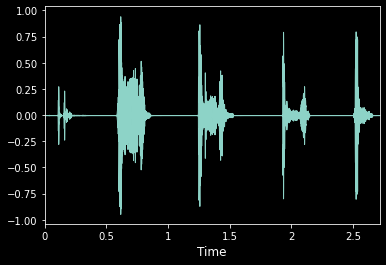

In [ ]:
# Viewing an example audio file
signal, sr = librosa.load('/cleaned_reduced_audio/pos/015576c8-2b03-4dcb-b251-78a984fe86fe.wav')
ldp.waveplot(signal, sr)

In [ ]:
# Copying our virufy audio data and joining it with our coughvid data
run=0
if run:
  virufy_base = '/virufy_reduced/'
  new_base = '/cleaned_reduced_audio/'

  for status in os.listdir(virufy_base):
    virufy_address = virufy_base + status + '/'
    new_address = new_base + status + '/'

    for audio in os.listdir(virufy_address):
      audio_file = virufy_address + audio
      shutil.move(audio_file, new_address)

In [ ]:
num_items('cleaned_reduced_audio/', ['pos/', 'neg/'])

cleaned_reduced_audio/
Number of items in pos/: 587
Number of items in neg/: 5699
Total number of items: 6286


6286

In [ ]:
# Moving a copy of our reduced audio to our google drive
run=0
if run:
  shutil.copytree('/cleaned_reduced_audio/', 
                  '/content/drive/MyDrive/gdrive/capstone/audio_folders/cleaned_reduced_audio/')

In [ ]:
# Checking to make sure our number of items is the same as the copied tree
num_items('/content/drive/MyDrive/gdrive/capstone/audio_folders/cleaned_reduced_audio/', ['pos/', 'neg/'])

/content/drive/MyDrive/gdrive/capstone/audio_folders/cleaned_reduced_audio/
Number of items in pos/: 587
Number of items in neg/: 5699
Total number of items: 6286


6286

In [ ]:
run=0
if run:
  reduced_df = get_audio_duration('/cleaned_reduced_audio/')

Time to run cell: 3758 seconds


In [ ]:
try:
  reduced_df.to_csv('/content/drive/MyDrive/gdrive/capstone/created_dfs/reduced_duration.csv')
except:
  pass

In [ ]:
try:
  reduced_duration_df = pd.read_csv('/content/drive/MyDrive/gdrive/capstone/created_dfs/reduced_duration.csv')
except:
  pass

In [ ]:
reduced_duration_df['duration'].describe()

count    6286.000000
mean        6.437051
std         2.666110
min         0.300000
25%         4.300000
50%         6.800000
75%         8.900000
max        14.900000
Name: duration, dtype: float64

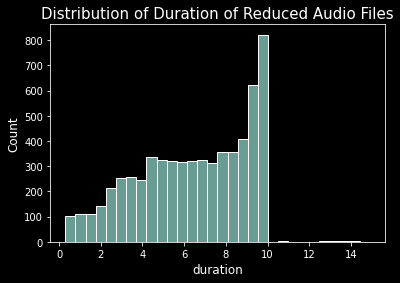

In [ ]:
sns.histplot(reduced_duration_df, x='duration')
plt.title('Distribution of Duration of Reduced Audio Files');

In [ ]:
reduced_duration_df['duration'].quantile(.99)

9.9

Unfortunately, the 99% percentile of this audio data is 9.9 seconds, whereas the untrimmed audio files that we worked with before was approximately 10.02 seconds. This means that we only managed to shave off 0.12 seconds of the 99th percentile for the data. 

## End Test Area

## Preparing Image Data Generators

### Creating train, test, and val folders

In [ ]:
# Splitting our spectrogram images into train, test, and validation subfolders

spectro_ttv = ensure_filepath('/spectro_ttv')

splitfolders.ratio(input=saved_spectro_images, 
                    output=spectro_ttv, 
                    seed=42, ratio=(0.7, 0.1, 0.2)) # ratio order: train, val, test

Copying files: 6252 files [00:01, 4347.30 files/s]


Using the zipped spectro_folders_zip file from here on to work with. Once we've run the above code, we manually zip the file outside google colab. We then bring it back in to unzip the folder. Google colab is able to access more quickly the data from a zipped folder when compared to an unzipped folder - which is saving us time.

In [ ]:
# Checking to make sure we still have the same number of images
folder_check(spectro_ttv, check=0)

/spectro_ttv/train/
Number of items in neg: 3967
Number of items in pos: 408
Total number of items: 4375

/spectro_ttv/test/
Number of items in neg: 1135
Number of items in pos: 118
Total number of items: 1253

/spectro_ttv/val/
Number of items in neg: 566
Number of items in pos: 58
Total number of items: 624


Total image count: 6252


In [ ]:
# Creating train, test, and validation folders
train_folder, test_folder, val_folder = create_ttv(spectro_ttv)

In [ ]:
train_folder

'/spectro_ttv/train/'

In [ ]:
# Setting batch size and image size
BATCH_SIZE = 32
IMG_SIZE = (200,500)

In [ ]:
# Creating image data generators and iterators to allow our folders to flow through
aug_spectro_datagen = ImageDataGenerator(rescale=1./255, 
                                         width_shift_range=0.1, 
                                         brightness_range=(0.9, 1.3), 
                                         zoom_range=0.1)

test_val_datagen = ImageDataGenerator(rescale=1./255)

train_spectro_gen = aug_spectro_datagen.flow_from_directory(train_folder, 
                                                   target_size=IMG_SIZE,
                                                   batch_size=BATCH_SIZE,
                                                   class_mode='binary')

test_spectro_gen = test_val_datagen.flow_from_directory(test_folder, 
                                                     target_size=IMG_SIZE,
                                                     batch_size=BATCH_SIZE,
                                                     class_mode='binary',
                                                     shuffle=False)

val_spectro_gen = test_val_datagen.flow_from_directory(val_folder, 
                                                    target_size=IMG_SIZE,
                                                    batch_size=BATCH_SIZE,
                                                    class_mode='binary')

Found 4342 images belonging to 2 classes.
Found 1244 images belonging to 2 classes.
Found 619 images belonging to 2 classes.


In [ ]:
# Viewing classes
train_spectro_gen.class_indices

{'neg': 0, 'pos': 1}

In [ ]:
# Viewing the shape
train_spectro_gen.image_shape

(200, 500, 3)

In [ ]:
# Viewing the spectrograms image shape
INPUT_SHAPE = train_spectro_gen.image_shape
print(INPUT_SHAPE)

(200, 500, 3)


In [ ]:
# Our classes are extremely unbalanced
class_weights_dict = make_class_weights(train_spectro_gen)

{0: 0.5515752032520326, 1: 5.347290640394089}


### Creating a basic model for spectrograms

In [ ]:
def spectro_model(shape='', opt=tf.keras.optimizers.Adam(), 
                        metrics=['acc', tf.keras.metrics.Precision(name='precision'),
                                        tf.keras.metrics.Recall(name='recall'), 
                                        tf.keras.metrics.AUC(name='auc')],
                        loss=tfa.losses.SigmoidFocalCrossEntropy(), 
                        verbose=1, padding='same'):
  """
  Definition:
  Creates and compiles a neural network model. 

  Args:
  shape: default = ''. The input shape of the images to be passed in to the 
  neural network. The size must be the same as the images being passed in.
  metrics: default = ['acc', tf.keras.metrics.Precision(name='precision'),
                             tf.keras.metrics.Recall(name='recall'), 
                             tf.keras.metrics.AUC(name='auc')].
           The metrics that are to be analyzed and plotted from the 
           training of the model. 
  loss: default = tfa.losses.SigmoidFocalCrossEntropy(). The loss metric used when
  the model is compiled.
  verbose: default = 1. If 1, prints a summary of the model upon compilation.

  Returns:
  The model, along with the model.summary() if verbose = 1.
  """
  if len(shape) < 1:
    print('Please define input shape!')
  else:
    model = Sequential()
    model.add(layers.Conv2D(32, (3,3), activation='relu', padding=padding, input_shape=shape))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(64, (3,3), activation='relu', padding=padding))
    model.add(MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding=padding))
    model.add(MaxPooling2D((2, 2)))

    # model.add(layers.Conv2D(256, (3, 3), activation='relu'))
    # model.add(MaxPooling2D((2, 2)))
    
    model.add(Flatten())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dropout(0.2))

    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.2))

    model.add(layers.Dense(128, activation='relu'))

    model.add(layers.Dense(64, activation='relu'))

    model.add(layers.Dense(32, activation='relu'))

    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(loss=loss, optimizer=opt, metrics=metrics)
    print(model.summary())
    return model

In [ ]:
def leaky_spectro_model(shape='', opt=tf.keras.optimizers.Adam(), alpha=0.2,
                          metrics=['acc', tf.keras.metrics.Precision(name='precision'),
                                        tf.keras.metrics.Recall(name='recall'), 
                                        tf.keras.metrics.AUC(name='auc')],
                        loss=tfa.losses.SigmoidFocalCrossEntropy(), verbose=1):
  """
  Definition:
  Creates and compiles a neural network model. Utilizes leaky ReLU instead of relu
  and the activation layer.

  Args:
  shape: default = ''. The input shape of the images to be passed in to the 
  neural network. The size must be the same as the images being passed in.
  metrics: default = ['acc', tf.keras.metrics.Precision(name='precision'),
                             tf.keras.metrics.Recall(name='recall'), 
                             tf.keras.metrics.AUC(name='auc')].
           The metrics that are to be analyzed and plotted from the 
           training of the model. 
  loss: default = tfa.losses.SigmoidFocalCrossEntropy(). The loss metric used when
  the model is compiled.
  verbose: default = 1. If 1, prints a summary of the model upon compilation.

  Returns:
  The model, along with the model.summary() if verbose = 1.
  """

  if len(shape) < 1:
    print('Please define input shape!')
  else:
    model = Sequential()
    model.add(layers.Conv2D(32, (3,3), input_shape=shape))
    model.add(layers.LeakyReLU(alpha=alpha))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(64, (3,3)))
    model.add(layers.LeakyReLU(alpha=alpha))
    model.add(MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(128, (5, 5)))
    model.add(layers.LeakyReLU(alpha=alpha))
    model.add(MaxPooling2D((4, 4)))

    model.add(layers.Conv2D(256, (3, 3)))
    model.add(layers.LeakyReLU(alpha=alpha))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Flatten())
    model.add(layers.Dense(256))
    model.add(layers.LeakyReLU(alpha=alpha))
    model.add(layers.Dropout(0.2))

    model.add(layers.Dense(128))
    model.add(layers.LeakyReLU(alpha=alpha))
    model.add(layers.Dropout(0.2))

    model.add(layers.Dense(64))
    model.add(layers.LeakyReLU(alpha=alpha))

    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(loss=loss, optimizer=opt, metrics=metrics)
    if verbose:
      print(model.summary())
    return model

In [ ]:
spectro_model1 = spectro_model(shape=INPUT_SHAPE)

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_23 (Conv2D)           (None, 200, 500, 32)      896       
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 100, 250, 32)      0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 100, 250, 64)      18496     
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 50, 125, 64)       0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 50, 125, 128)      73856     
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 25, 62, 128)       0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 198400)           

Epoch 1/5
136/136 [==============================] - 433s 3s/step - loss: 0.1075 - acc: 0.8786 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4752 - val_loss: 0.0674 - val_acc: 0.9079 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5492
Epoch 2/5
136/136 [==============================] - 421s 3s/step - loss: 0.0741 - acc: 0.9030 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4876 - val_loss: 0.0517 - val_acc: 0.9079 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5493
Epoch 3/5
136/136 [==============================] - 427s 3s/step - loss: 0.0706 - acc: 0.9110 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5100 - val_loss: 0.0636 - val_acc: 0.9079 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5325
Epoch 4/5
136/136 [==============================] - 423s 3s/step - loss: 0.0725 - acc: 0.9046 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5530 - val_loss: 0.0721 - val_acc: 0.9079 - val_precision: 0.0000

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


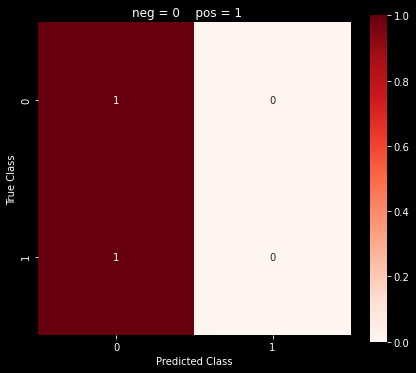

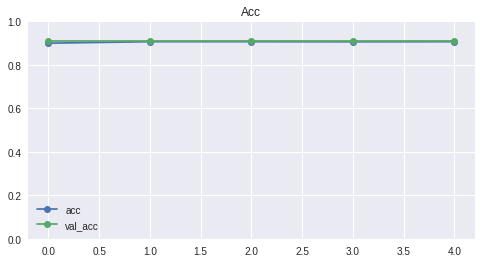

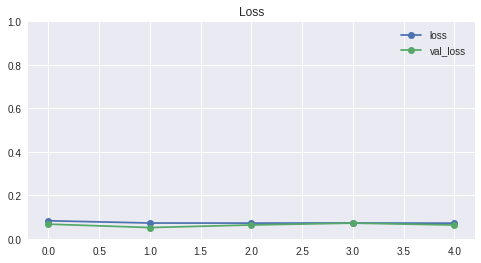

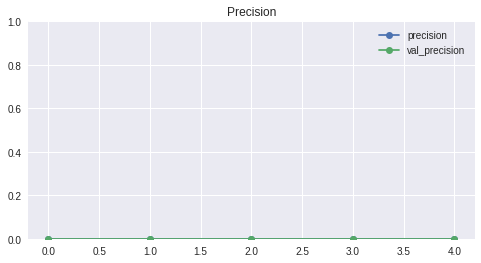

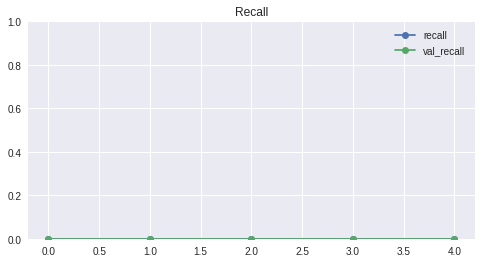

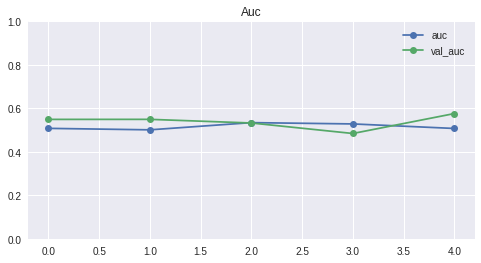

------------------------------------------------------------
39/39 [==============================] - 78s 2s/step - loss: 0.0635 - acc: 0.9051 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5751
loss score: 0.0634758397936821
accuracy score: 0.9051446914672852
precision score: 0.0
recall score: 0.0
auc score: 0.5750632882118225

Time to run cell: 2285 seconds


In [ ]:
spectro_fpr = fit_plot_report_gen(spectro_model1, train_spectro_gen, 
                                  test_spectro_gen, val_spectro_gen, epochs=5, 
                                  class_weights=class_weights_dict)

Our model is having a very difficult time differentiating between our classes. Even though we used class weights, our model is only guessing every label as the majority label (healthy). So while our model is giving us an 91% accuracy, it is basically useless. Let's try and give our model more COVID images to look at. In our next step, we will create augmented images of the minority class from the training set and balance the training set with those augmented images.

### Oversampling with Image Augmentation Manipulation

We are going to attempt to address the class imbalance by creating augmented images of the minority class spectrograms and combine these images with our training folder to create a faux-balanced dataset.

In [ ]:
# We are going to create augmented images from our training folder's minority
# class and save them into a new directory
train_folder = spectro_ttv + 'train/'
train_minority_folder = train_folder + 'pos/'
train_majority_folder = train_folder + 'neg/'

#Viewing the number of images in our majority class of the training folder
print(f"Number of images in majority class: {len(os.listdir(train_majority_folder))}\n"
      f"Number of images in minority class: {len(os.listdir(train_minority_folder))}")

Number of images in majority class: 3967
Number of images in minority class: 408


### Creating a copy of spectro_folder and removing all majority class images

In [ ]:
# copying the train folder
train_copy = ensure_filepath('/train_copy')

shutil.copytree(train_folder, train_copy)

'/train_copy/'

In [ ]:
# Verifying that the amount of images in the copied folder is the same as the 
# original folder
num_items(train_copy, targets=['pos/', 'neg/'])

/train_copy/
Number of items in pos/: 408
Number of items in neg/: 3967
Total number of items: 4375


4375

In [ ]:
# removing all negative images within the copied train folder
shutil.rmtree(train_copy + 'neg/')
# recreating the 'neg/' subfolder in our copied train folder
os.makedirs(train_copy + 'neg/')

In [ ]:
# Verifying that we have removed all images in the negative folder
num_items(train_copy, targets=['pos/', 'neg/'])

/train_copy/
Number of items in pos/: 408
Number of items in neg/: 0
Total number of items: 408


408

#### Minority Data Generator

In [ ]:
# Creating a data generator for the minority class
min_datagen = ImageDataGenerator(rescale=1./255,  
                                 width_shift_range=0.1, 
                                 channel_shift_range=0.2, 
                                 shear_range=0.2, 
                                 brightness_range=[0.75, 1.3])
IMG_SIZE = (200,500)

In [ ]:
# Making a directory to store the augmented images
aug_dir = ensure_filepath('/aug_images/')

os.makedirs(aug_dir, exist_ok=True)

aug_iter = min_datagen.flow_from_directory(train_copy, 
                                           target_size=IMG_SIZE, 
                                           batch_size=406, 
                                           save_to_dir=aug_dir, 
                                           save_prefix='aug', 
                                           shuffle=True)

Found 408 images belonging to 2 classes.


In [ ]:
diff = len(os.listdir(train_majority_folder)) - len(os.listdir(train_minority_folder))
print(f"Difference between classes: {diff}")

Difference between classes: 3559


In [ ]:
# Creating 3530 augmentations of our minority class images in our train folder
# Adding these augmentation images to our positive images will balance our classes
start = time.time()

while len(os.listdir(aug_dir)) < diff:
  next(aug_iter)

end = time.time()
time_count(start, end)

Time to run cell: 36 seconds


In [ ]:
# Viewing the amount of augmented images we've created so far
len(os.listdir(aug_dir))

3936

In [ ]:
# Removing random augmented image files from our augmented image folder so the 
# classes will be equal

while len(os.listdir(aug_dir)) > diff:
  rand_chosen = np.random.choice(os.listdir(aug_dir))
 
  random_path = aug_dir + rand_chosen
  try:
    os.remove(random_path)
  except:
    continue


In [ ]:
len(os.listdir(aug_dir))

3559

In [ ]:
def display_images(source, amnt_to_display):
  """
  Definition:
  Define the 'source' variable by giving it a filepath containing images along with
  setting the number you wish to view through the variable 'amnt_to_display'. The
  function will plot the selected number of images within the file and display them.

  Args:
  source: Required. A filepath containing images.
  amnt_to_display: Required. The number of images you wish to display.

  Returns:
  Plots a certain amount of images from the selected filepath.
  """
  
  plt.figure(figsize=(20,10))
  cols = amnt_to_display//2
  images = os.listdir(source)[:amnt_to_display]
  for i, img in enumerate(images):
      #Opening each image from its respective filepath
      x_image = Im.open(source+img)
      # defining the position for each subplot 
      # subplot(nrows, ncols, index)
      plt.subplot(len(images) / cols + 1, cols, i + 1)
      #plotting each image in a new subplot
      plt.imshow(x_image)
      # Hiding the x and y axis tick marks
      plt.xticks([])
      plt.yticks([])
      # fitting the images closer together
      plt.tight_layout()

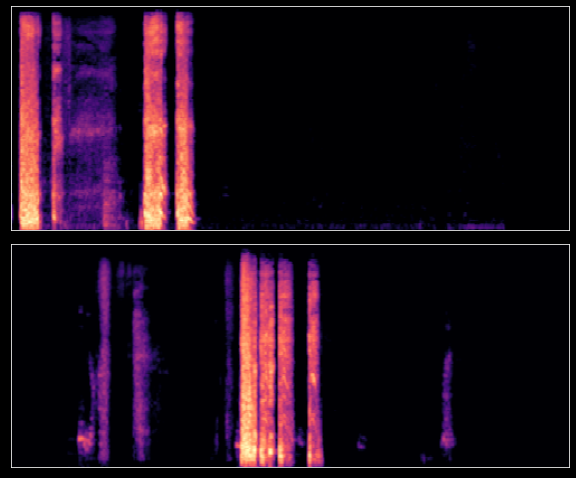

In [ ]:
display_images(aug_dir, amnt_to_display=2)

In [ ]:
# Making another copy of our spectrogram folder - we will use this one to model
# with. We are going to add our augmentations into the minority class of the 
# training folder
spectro_modeling_set = ensure_filepath('/spectro_modeling_set/')

shutil.copytree(spectro_ttv, spectro_modeling_set)

'/spectro_modeling_set/'

In [ ]:
# Viewing the number of images in each class for each subfolder
folder_check(spectro_modeling_set)

/spectro_modeling_set/train/
Number of items in neg: 3967
Number of items in pos: 408
Total number of items: 4375

/spectro_modeling_set/test/
Number of items in neg: 1135
Number of items in pos: 118
Total number of items: 1253

/spectro_modeling_set/val/
Number of items in neg: 566
Number of items in pos: 58
Total number of items: 624


Total image count: 6252


In [ ]:
# Copying over our augmented images into the training minority class folder ('pos')
for f in os.listdir(aug_dir):
  shutil.copy(aug_dir + f, spectro_modeling_set + 'train/pos/')

In [ ]:
# Sanity check
folder_check(spectro_modeling_set)

/spectro_modeling_set/train/
Number of items in neg: 3967
Number of items in pos: 3967
Total number of items: 7934

/spectro_modeling_set/test/
Number of items in neg: 1135
Number of items in pos: 118
Total number of items: 1253

/spectro_modeling_set/val/
Number of items in neg: 566
Number of items in pos: 58
Total number of items: 624


Total image count: 9811


In [ ]:
# Creating strings to define the address for each train, test, and val folder
train_spec, test_spec, val_spec = create_ttv(spectro_modeling_set)

In [ ]:
# Setting batch size and image size
#train_batch, test_batch, val_batch = batch_sizes([train_spec, test_spec, val_spec])
IMG_SIZE = (200, 500)

In [ ]:
# Rescaling the images to floats based off of the RGB intensity values (0-255)
# This way, the values will be numbers somewhere between 0 and 1.
spec_gen = ImageDataGenerator(rescale=1./255)

# Creating iterators for train, test, and val sets
train_spec_gen = spec_gen.flow_from_directory(train_spec, 
                                              target_size=IMG_SIZE,
                                              batch_size=32,
                                              class_mode='binary', 
                                              shuffle=True)

test_spec_gen = spec_gen.flow_from_directory(test_spec, 
                                             target_size=IMG_SIZE,
                                             batch_size=32,
                                             class_mode='binary', 
                                             shuffle=False)

val_spec_gen = spec_gen.flow_from_directory(val_spec, 
                                            target_size=IMG_SIZE,
                                            batch_size=32,
                                            class_mode='binary', 
                                            shuffle=True)

Found 7934 images belonging to 2 classes.
Found 1253 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
# Since our class weights should be even, we don't need the class weights for 
# this modeling process
class_weights_dict = make_class_weights(train_spec_gen)

{0: 1.0, 1: 1.0}


In [ ]:
INPUT_SHAPE = train_spec_gen.image_shape
INPUT_SHAPE

(200, 500, 3)

In [ ]:
spectro_model3 = spectro_model(INPUT_SHAPE, opt=tf.keras.optimizers.Adam(learning_rate=0.001, 
                                                                         decay=0.0001))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 200, 500, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 100, 250, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 250, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 125, 64)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 125, 128)      73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 25, 62, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 198400)            0

Epoch 1/10
248/248 [==============================] - 295s 1s/step - loss: 0.0744 - acc: 0.5235 - precision: 0.6006 - recall: 0.0840 - auc: 0.6273 - val_loss: 0.0334 - val_acc: 0.9071 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4902
Epoch 2/10
248/248 [==============================] - 293s 1s/step - loss: 0.0406 - acc: 0.7780 - precision: 0.9853 - recall: 0.5556 - auc: 0.8875 - val_loss: 0.0357 - val_acc: 0.9071 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5132
Epoch 3/10
248/248 [==============================] - 290s 1s/step - loss: 0.0560 - acc: 0.6983 - precision: 0.9323 - recall: 0.4301 - auc: 0.8192 - val_loss: 0.0815 - val_acc: 0.9071 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5098
Epoch 4/10
248/248 [==============================] - 288s 1s/step - loss: 0.0505 - acc: 0.6832 - precision: 0.9457 - recall: 0.3915 - auc: 0.8617 - val_loss: 0.0410 - val_acc: 0.9054 - val_precision: 0.0000e+00 - val_recall: 0.0000e+0

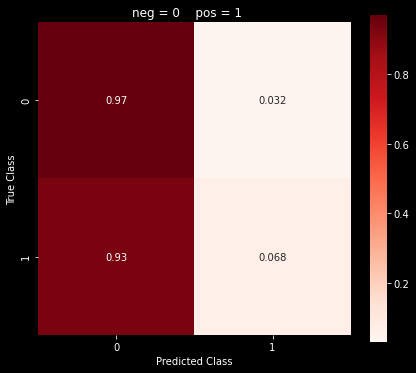

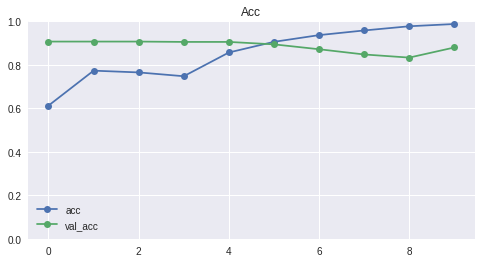

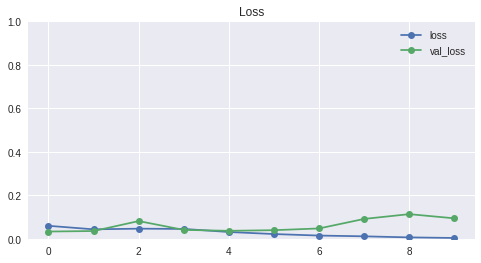

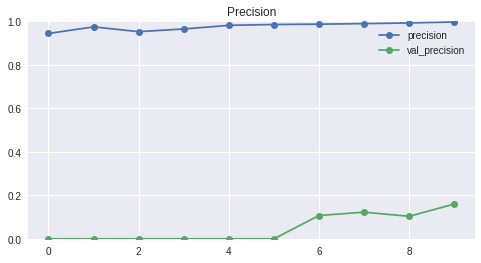

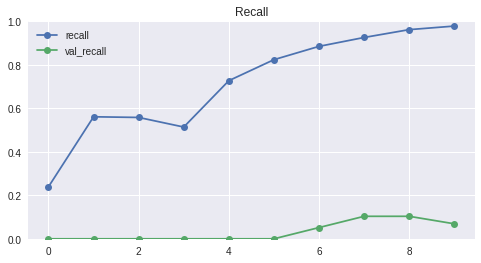

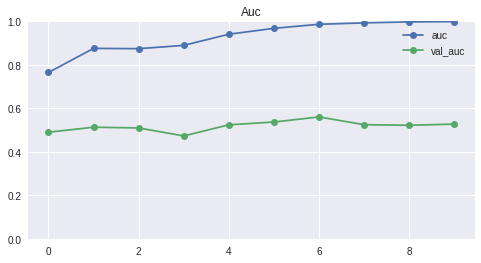

------------------------------------------------------------
40/40 [==============================] - 69s 2s/step - loss: 0.0962 - acc: 0.8835 - precision: 0.1818 - recall: 0.0678 - auc: 0.5808
loss score: 0.09616518020629883
accuracy score: 0.883479654788971
precision score: 0.1818181872367859
recall score: 0.06779661029577255
auc score: 0.5807623267173767

Time to run cell: 3033 seconds


In [ ]:
spectro_oversamp_fpr = fit_plot_report_gen(spectro_model3, train_spec_gen, test_spec_gen, val_spec_gen, 
                                           epochs=10)

# Interpretation



Our model had an accuracy of 88% with a recall of around 13.5%. This model is performing better than our first model that used the spectrograms without augmentation, in  terms of recall scoring (the first model had a recall rate of 0). This model is still having a difficult time differentiating the correct class based off of the spectrogram images alone. Our AUC improved slightly improved, however it is still too low of a score to trust this model's ability to classify COVID-19 in a patient's cough audio.

#### Possible reasons our models are struggling to differentiate between classes:

1. The silence in audio files may be introducing ambiguity into the models, which could be interfering with our model's accuracy and ability to differentiate between the classes.
2. Our model could struggling with identifying the different classes due to the heavy class imbalance.
3. The labels that were marked in the coughvid dataset 'status' column were self-reported, so there could be noise in the labels.
4. The model may not be able to find any patterns in the spectrograms we created from the audio files.
5. Our model may not be complex enough to find any patterns in our spectrograms.
6. The difference in duration between audio files may be too great; some are 2 second audio files with 8 seconds of zero padding, which could be affecting the model's ability to correctly classify.
7. More data may be required.

## Recommendations Section

Taking advantage of the splitfolders library is a great and easy way to create train, test, and validation folders for any type of classification data - as long as the classes are predefined in their own folders. 

I highly recommend using CLAHE as a preprocessing technique if you're working with images like x-rays or MRI scans. CLAHE is able to provide enough contrast to the image without overamplifying the intensity of the pixels, providing more 'depth' within each image. It is a great tool if the goal of your project involves detection and/or recognition between classes.

The librosa library is filled with tools to help assist with manipulating audio, extracting features, and creating different plots of different audio transformations. If you end up working with audio data, I recommend implementing the librosa library to help explore and create valuable features and plots from the audio data.

When working with spectrograms created from human audio, taking the log of the amplitude and converting it to decibels will give your model more to look at, and allow it to learn more from each image. Since we are working with coughing audio, converting the frequency to the mel-scale allows us to peer more into the tonal relationship of the frequencies.

While my audio model still needs more work and further exploration, I recommend health companies to invest in obtaining high quality COVID-19 positive audio data with expert-confirmed labels. Having publicly accessible high quality data would be the key to helping prevent the further spread of COVID-19, and possible future variants/strains of coronavirus. 

## Conclusion

The cough data we retrieved is currently (early 2021) sparse and hard to come by. COVID-19 audio datasets of high quality with laboratory-diagnosed labels are rare and many institutions that are working on cleaning their data for their own models have yet to make their data available to the public (such as University of Cambridge, Massachussetts Institute of Technology, NIH, etc.). There are different ways other researchers have gone about using Convolutional Neural Networks with cough audio data, such as: spectrograms, Mel-Frequency cepstral coefficients, audio feature extraction, and mel-spectrograms why trying to classify the COVID-19 cough audio. While I was unable to get any real traction when it came to classifying COVID through the use of spectrograms, I learned a lot about manipulating auditory data. Even though the models did not perform to my expectation, I'm sure the knowledge I've gained from this project could be useful when identifying other health-related events, such as detecting heart diseases based off of electrocardiographies or heartbeat audio. While I am nowhere near done with this project, I can say I've fully enjoyed the entire process.

## Future Research

While I have only been able to explore a few different methods when creating spectrograms, I have a lot of different options in front of me in terms of identifying further ways to tackle this problem. Finding other coughing audio through other sources could prove to be beneficial, especially if the audio is high quality with laboratory confirmed labels. Using different parameters when creating the spectrograms could also help the model's recognition ability. We could also try other audio imaging techniques like Mel-Frequency Cepstral Coefficients (MFCCs), or even try feature extraction to try and find key features that impact the detection efficiency when using the model to diagnose the audio.  

Another tactic that I will try will involve setting the audio files to a lower time duration before creating the spectrograms. I've realized that some of the audio (like the virufy audio) is less than 2 seconds in duration. By zero padding 8 seconds to the audio file, there may not be much information the model can really work with. So my idea is to clip the silence off the ends of the audio files, then cut each audio file in half that is greater than 6 seconds in duration. Another similar option would be to create 2 second segments for each audio file, and zero pad audio files that are less than 2 seconds in duration. This way, I'd be reducing the width of the spectrograms and giving the models more to look at. 

## References

1. M.E.H. Chowdhury, T. Rahman, A. Khandakar, R. Mazhar, M.A. Kadir, Z.B. Mahbub, K.R. Islam, M.S. Khan, A. Iqbal, N. Al-Emadi, M.B.I. Reaz, M. T. Islam, “Can AI help in screening Viral and COVID-19 pneumonia?” IEEE Access, Vol. 8, 2020, pp. 132665 - 132676.

2. Lara Orlandic, Tomas Teijeiro, & David Atienza. (2020). The COUGHVID crowdsourcing dataset: A corpus for the study of large-scale cough analysis algorithms (Version 1.0) [Data set]. Zenodo. http://doi.org/10.5281/zenodo.4048312

3. Chaudhari, Gunvant, et al. "Virufy: Global Applicability of Crowdsourced and Clinical Datasets for AI Detection of COVID-19 from Cough." arXiv preprint arXiv:2011.13320 (2020).

4. Hosseiny M, Kooraki S, Gholamrezanezhad A, Reddy S, Myers L. Radiology Perspective of Coronavirus Disease 2019 (COVID-19): Lessons From Severe Acute Respiratory Syndrome and Middle East Respiratory Syndrome. AJR Am J Roentgenol2020;214:1078-82. doi:10.2214/AJR.20.22969 pmid:32108495